# Attack viz

### Background

For a better understanding of the situation, please check the [slides](https://docs.google.com/presentation/d/1oDi0Ds2l3TXghT6AvLKKgyhFA--uFD9d9vGC6eFooss/edit?usp=sharing)  (An epfl authentication is needed to gain access)

Here are the following steps that the attacker take in order to carry on his attack: 
    
    1) Extract the information about the packages that the victim can download by crawling all 
       the metadata in var/lib/   (crawl dir.)
       
    2) Do some cleaning and statistics about the the freshly crawled data. (attack dir.)
    
    3) Capture the victims traffic on updates (for now lab condition) (capture dir.)
    
    4) Match the capture with a specific update (attack dir.)
    
    

We suppose in this notebook that the Attacker already collected/process the following data:
 - `ground_through` : where hypothetically all the packages metadata are up-to-date
 - `gt` : the cleaned version of `ground_truth` processed by the attacker
 - `attack_table` : Containing the capture of the packages that the attacker wants to match
 - `*_old` : old version of the above

 __Please Run Setup before jumping to sections__

### Table of Content <a id = 'tc'></a>

 - [Set Up](#Setup)
 - [Uniqueness investigation & Cleaning ](#cleaning)
 - Mounting an Attack
     - [Relying on HTTP request](#Mounting_an_Attack_HTTP)
     - [Relying only on packages size](#Mounting_an_Attack_SIZE)
     
 - Dependens discovery
     - [Dependens](#dependens_discovery)
     - [Recommends and Suggests](#recommends_and_suggests)
 - Gstreamer
     - [Problem](#gstreamer)
     - [Fixed](#gstreamer_fixed)
 - Mueval
     - [Problem](#mueval_problem)
 - [Kernel Packages](#kernels)
 - [Changement over Time of crawled packages](#time_changement)
 - [Unicity](#unicity)
 - [Signature](#signatures)
 
<a id='Setup'></a>
## Set up 

In [2]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
%matplotlib inline
import numpy as np
import dask.dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count
from dask.diagnostics import ProgressBar

cores = cpu_count() #Number of CPU cores available

tqdm.pandas()

# Helper function to load a table 
def load_fingerpatch(table, dbname = "fingerpatch"):
    """Load table in the dbname and format it"""
    modes = ["Depends", "Recommends", "Suggests"]
    
    connection = pymysql.connect(host='localhost',
                                 user='fingerpatch',
                                 password='fingerpatch',
                                 db=dbname,
                                 charset='utf8mb4',
                                 cursorclass=pymysql.cursors.DictCursor)
    df = pd.read_sql("SELECT * FROM `"+table+"` ",connection)
    connection.close()
    
    if table == "ubuntu_packets":
        df = df.set_index("id")
            
    if table == "ubuntu_cleaned_packets":
        df = df.set_index("id")
        
        if "Childrens" in df.columns:
            df["Childrens"] = df["Childrens"].map(eval)
        
        for m in modes:
            attr = m + "_Childrens"
            if attr in df.columns:
                df[attr] = df[attr].map(eval)
            
    if table == "ubuntu_captures":
        df = df.set_index("capture_id")
        df["HTTP_Seq"] = df["HTTP_Seq"].map(eval)
        df["Payload_received"] = df["Payload_received"].map(eval)
        df["Payload_sent"] = df["Payload_sent"].map(eval)
        df["Flows"] = df["Flows"].map(eval)        
        
    return df

def generate_count_on_depend(ground_truth):

    ground_truth = ground_truth.fillna("")
    ground_truth["#Depends"] = ground_truth["Depends"].map(lambda x: 0 if x == "" else len(x.split(",")))

    if "Recommends" in ground_truth.columns:
        ground_truth["#Recommends"] = ground_truth["Recommends"].map(lambda x: 0 if x == "" else len(x.split(",")))
    if "Suggests" in ground_truth.columns:
        ground_truth["#Suggests"] = ground_truth["Suggests"].map(lambda x: 0 if x == "" else len(x.split(",")))

    return ground_truth  


def remove_useless(ground_truth):
    # Selecting only interessting fields i.e. the attacker has no mean to distinguish two packages that have the same size but different packageMode
    ground_truth = ground_truth.drop_duplicates(['Package', 'Version', 'Size', 'Depends', 'Architecture'])

    # Make sure that there is no duplicate information (For a given Package name and Version we have at most one match)
    print("The maximum duplication of rows that have the same Package name and Version is: ", ground_truth.groupby(by=["Package", "Version"]).count()["SHA1"].max())

    # Selecting only interessting columns
    ground_truth = ground_truth.drop(axis= 1, columns=['capture_id','SHA1', 'Priority', 'Description-md5', 'MD5sum', 'SHA256', 'packageMode' ])

    ground_truth = ground_truth.fillna("")
    print("Total entries after having cleaned: ", len(ground_truth))
    return ground_truth

<a id='cleaning'></a>
## Uniqueness investigation & Cleaning 

This step is taken by the attacker at the very beginning. Once he crawled the raw packages, he has to clean his data. This is an intermediate step before getting the `gt` dataframe.


Select interesting columns and remove duplicated rows

In [2]:
ground_truth = load_fingerpatch(dbname="fingerpatch", table="ubuntu_packets" )
ground_truth.columns

Index(['capture_id', 'Package', 'Version', 'Architecture', 'Size',
       'Installed-Size', 'Priority', 'Maintainer', 'SHA1', 'Description',
       'parsedFrom', 'Description-md5', 'Bugs', 'Origin', 'MD5sum', 'Depends',
       'Recommends', 'Suggests', 'Homepage', 'Source', 'SHA256', 'Section',
       'Supported', 'Filename', 'packageMode'],
      dtype='object')

In [44]:
print("Total entries without having cleaned: ", len(ground_truth))
ground_truth = remove_useless(ground_truth)

Total entries without having cleaned:  129278
The maximum duplication of rows that have the same Package name and Version is:  1
Total entries after having cleaned:  57167


<a id='Mounting_an_Attack_HTTP'></a>
## Mounting an Attack for matching a specific capture to a package.

[Table of content](#tc)

### Relying on HTTP request
The aim here is to find a match from the attacker's captured HTTP request to the ground_truth database

Let's set the following target we want to match:

In [104]:
gt =load_fingerpatch(dbname="fingerpatch_old", table="ubuntu_cleaned_packets" )
attack_table = load_fingerpatch(dbname="fingerpatch_old", table="ubuntu_captures")
target = attack_table.iloc[1]
target

truth_id                                                        42120
nb_flows                                                            3
HTTP_Seq            [GET /ubuntu/pool/universe/libs/libswingx-java...
Flows               [target->economy.canonical.com, economy.canoni...
Payload_sent                                                 [0, 163]
Payload_received                                            [1444169]
matched                                                             1
Name: 2, dtype: object

In [105]:
target["HTTP_Seq"]

['GET /ubuntu/pool/universe/libs/libswingx-java/libswingx-java_1.6.2-1_all.deb HTTP/1.1']

In [106]:
print("\nAnd we got the following file name in the ground_truth: \n\n",gt.loc[42120]["Filename"] )


And we got the following file name in the ground_truth: 

 pool/universe/libs/libswingx-java/libswingx-java_1.6.2-1_all.deb


Thererfore, we notice that the attribute `Filename` match the HTTP request pretty well, except that, in the HTTP request, the beginning of the root in the url begin with `/ubuntu/` . So if the victim use the pure HTTP protocol, the attacker should be able to match exactly all the package. There are some little issues easy to fix: 

In [107]:
print("In the ground_truth: \n\n",ground_truth.loc[14404]["Filename"])
print("\nIn the attacker's table after having parsed: \n\n", attack_table.loc[32]["HTTP_Seq"][0])

In the ground_truth: 

 pool/universe/f/freepops/freepops-updater-fltk_0.2.9-8_amd64.deb

In the attacker's table after having parsed: 

 GET /ubuntu/pool/main/d/dee/libdee-doc_1.2.7%2b14.04.20140324-0ubuntu1_all.deb HTTP/1.1


Here we see that the HTTP request changes `+` in `%2b`. So we need to parse the HTTP sequence and change it before the matching

In [108]:
def matchHTTP(x, df):
    """
    x String contraining the filename
    To use with a map on the attribute FileName
    """

    requests = x

    match = []
    

    for r in requests:
        s = r.split(" ")[1][8:]
        if len(s) < 20: # With only 20 character we reckon that the request doesn't contain enough information for a perfect match
            continue

        s = s.replace("%2b", "\+")
        found = df[df.Filename.str.contains(s)]
        match += found.index.tolist()

    # remove duplicates
    match = list(set(match))

    return match

attack_table["Http Match"] = attack_table["HTTP_Seq"].map(lambda x: matchHTTP(x, gt))

In [109]:
attack_table[["truth_id", "nb_flows", "Http Match"]].tail()

,truth_id,nb_flows,Http Match
capture_id,,,
28,17242,3,[17242]
29,29129,3,[29129]
30,39206,3,[39206]
31,17242,3,[17242]
32,14404,3,[14404]


We found the perfect match each time we could capture the HTTP Seq.

<a id='Mounting_an_Attack_SIZE'></a>
### Relying on package size

We pick the same target as in the previous section

In [114]:
target = attack_table.loc[32]
target

truth_id                                                        14404
nb_flows                                                            3
HTTP_Seq            [GET /ubuntu/pool/main/d/dee/libdee-doc_1.2.7%...
Flows               [target->yukinko.canonical.com, yukinko.canoni...
Payload_sent                                                 [0, 165]
Payload_received                                              [58743]
matched                                                             0
Http Match                                                    [14404]
Name: 32, dtype: object

In [125]:
EXTRA_SIZE_AVERAGE = 283   # Made from stats about captured packets
EXTRA_SIZE_VARIATION = 5

In [126]:
# When matching with Size
def distance_from_expected_average_size(x, size_to_match):
    return abs(size_to_match - x["Summing dependances"] - (EXTRA_SIZE_AVERAGE * x["Elements involved"]))

gt["dist_from_expected_size"] = gt.apply(lambda x: distance_from_expected_average_size(x, sum(target['Payload_received']) ), axis = 1)

In [132]:
gt.sort_values(by="dist_from_expected_size").head()

,Package,Version,Size,Filename,Summing dependances,Elements involved,Childrens,Frequency,Freq in p,dist_from_expected_size
id,,,,,,,,,,
14404,libdee-doc,1.2.7+14.04.20140324-0ubuntu1,58462,pool/main/d/dee/libdee-doc_1.2.7+14.04.2014032...,58462,1,{14404},1,0,2
49384,python-pyme-doc,1:0.8.1-2build1,58478,pool/universe/p/pyme/python-pyme-doc_0.8.1-2bu...,58478,1,{49384},1,0,18
2516,libmbim-glib-doc,1.6.0-2ubuntu0.1,58366,pool/main/libm/libmbim/libmbim-glib-doc_1.6.0-...,58366,1,{2516},1,0,94
15284,libjarjar-java-doc,1.4+svn142-3,58572,pool/main/j/jarjar/libjarjar-java-doc_1.4+svn1...,58572,1,{15284},1,0,112
33252,libgentlyweb-utils-java,1.5-1,58594,pool/universe/g/gentlyweb-utils/libgentlyweb-u...,58594,1,{33252},6,0,134


The first one is the one.

In [128]:
target

truth_id                                                        14404
nb_flows                                                            3
HTTP_Seq            [GET /ubuntu/pool/main/d/dee/libdee-doc_1.2.7%...
Flows               [target->yukinko.canonical.com, yukinko.canoni...
Payload_sent                                                 [0, 165]
Payload_received                                              [58743]
matched                                                             0
Http Match                                                    [14404]
Name: 32, dtype: object

<a id='dependens_discovery'></a>
## Dependens discovery

[Table of content](#tc)



Let's create an attribute `#Depends` which compute the number of Dependences a specific Package contains
and take a Package that has only one Dependence.

In [6]:
ground_truth =load_fingerpatch(dbname="fingerpatch", table="ubuntu_packets" )
ground_truth = remove_useless(ground_truth)
    
# Take the smallest packet that have only one Dependences
ground_truth = generate_count_on_depend(ground_truth)
one_dep_first10 = ground_truth[ground_truth["#Depends"] == 1].sort_values(by = "Size", ascending=True)[:10]
one_dep = one_dep_first10.iloc[0]
one_dep[["Package", "Version", "Depends", "#Depends"]]

The maximum duplication of rows that have the same Package name and Version is:  1
Total entries after having cleaned:  57167


Package            readpst
Version     0.6.59-1build1
Depends          pst-utils
#Depends                 1
Name: 51369, dtype: object

Seeking about that depends

In [164]:
ground_truth[ground_truth["Package"] == one_dep["Depends"]].iloc[0][["Package", "Version", "Depends","#Depends", "Size"]]

Package                                             pst-utils
Version                                        0.6.59-1build1
Depends     libc6 (>= 2.14), libgcc1 (>= 1:4.1.1), libgd3 ...
#Depends                                                    7
Size                                                    62092
Name: 18280, dtype: object

Turns out that this Dependens also have its Dependances

#### Once Downloading the package `readpst` we can ideed see that the package doesn't just depends on one single package but many subpackages from that dependance:

On the Docker:

`The following extra packages will be installed:
  fontconfig-config fonts-dejavu-core libfontconfig1 libfreetype6 libgd3
  libglib2.0-0 libglib2.0-data libgsf-1-114 libgsf-1-common libjbig0
  libjpeg-turbo8 libjpeg8 libpst4 libtiff5 libvpx1 libx11-6 libx11-data
  libxau6 libxcb1 libxdmcp6 libxml2 libxpm4 pst-utils sgml-base
  shared-mime-info xml-core`
  
`0 upgraded, 27 newly installed, 0 to remove and 32 not upgraded.
Need to get 5664 kB of archives.`


On the attacker:

`historic =  ['target->danava.canonical.com', 'danava.canonical.com->target', 'target->danava.canonical.com']
server_ip =  ['91.189.88.149', '172.100.0.100', '91.189.88.149']
server_name =  ['danava.canonical.com', 'target', 'danava.canonical.com']
received_Payload =  [5671834]
send_Payload =  [0, 4251]`

So if we calculate with the tipical extra_size for each downloaded package that we get on the attacker side and knowing that 5664kB is rounded:


In [161]:
EXTRA_SIZE_AVERAGE * 27 + 5664000

5671641

#### Let's find out what happens if we download the dependance before  

While downloading pst-utils (*using apt-get install readpst*):

On the victim:

`The following extra packages will be installed:
  fontconfig-config fonts-dejavu-core libfontconfig1 libfreetype6 libgd3
  libglib2.0-0 libglib2.0-data libgsf-1-114 libgsf-1-common libjbig0
  libjpeg-turbo8 libjpeg8 libpst4 libtiff5 libvpx1 libx11-6 libx11-data
  libxau6 libxcb1 libxdmcp6 libxml2 libxpm4 sgml-base shared-mime-info
  xml-core
0 upgraded, 26 newly installed, 0 to remove and 32 not upgraded.
Need to get 5663 kB of archives.`


On the Attacker:

`historic =  ['target->keeton.canonical.com', 'keeton.canonical.com->target', 'target->keeton.canonical.com']
server_ip =  ['91.189.88.161', '172.100.0.100', '91.189.88.161']
server_name =  ['keeton.canonical.com', 'target', 'keeton.canonical.com']
received_Payload =  [5670760]
send_Payload =  [0, 4085]
Ressources cleaned.`


In [162]:
print(" -- Seen By the Attacker -- Difference by downloading the full package and only it's dependances :",5671834 - 5670760)
print(" -- For the ground_truth -- Difference by downloading the full package and only it's dependances :",796 + EXTRA_SIZE_AVERAGE)

 -- Seen By the Attacker -- Difference by downloading the full package and only it's dependances : 1074
 -- For the ground_truth -- Difference by downloading the full package and only it's dependances : 1079


Now that the dependance is installed on the vicitim's machine, we perfom the update of the principal package:


On the victim:

`The following NEW packages will be installed:
  readpst
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 796 B of archives.
After this operation, 21.5 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu/ trusty/universe readpst all 0.6.59-1build1 [796 B]
Fetched 796 B in 0s (3656 B/s)   
Download complete and in download only mode`

On the attacker

`historic =  ['target->steelix.canonical.com', 'steelix.canonical.com->target', 'target->steelix.canonical.com']
server_ip =  ['91.189.88.152', '172.100.0.100', '91.189.88.152']
server_name =  ['steelix.canonical.com', 'target', 'steelix.canonical.com']
received_Payload =  [1074]
send_Payload =  [0, 155]`


Indeed, once the dependance is installed, installing just the package 

In [17]:
1074 - 796

278

#### SumOfDependences & NumberOfDependances

In [169]:
one_dep_first10.iloc[2]

capture_id                                                         1
Package                                                         gcom
Version                                                       0.32-2
Architecture                                                     all
Size                                                             820
Installed-Size                                                    20
Priority                                                    optional
Maintainer         Ubuntu Developers <ubuntu-devel-discuss@lists....
SHA1                        268fda01f3ca166ad944994e4c20e23ef8d6d3b9
Description             datacard control tool - transitional package
parsedFrom         packages/archive.ubuntu.com_ubuntu_dists_trust...
Description-md5                     e0904494174d371cf653d9f2366a4e96
Bugs                      https://bugs.launchpad.net/ubuntu/+filebug
Origin                                                        Ubuntu
MD5sum                            

In [20]:
ground_truth[ground_truth["Package"] == "comgt"]

,Package,Version,Architecture,Size,Installed-Size,Maintainer,Description,parsedFrom,Bugs,Origin,Depends,Homepage,Source,Section,Supported,Filename,#Depends
id,,,,,,,,,,,,,,,,,
139974,comgt,0.32-2,amd64,42804,188,Ubuntu Developers <ubuntu-devel-discuss@lists....,Option GlobeTrotter and Vodafone datacard cont...,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,libc6 (>= 2.7),http://www.pharscape.org/,,universe/net,,pool/universe/c/comgt/comgt_0.32-2_amd64.deb,1


In [21]:
ground_truth[ground_truth["Package"] == "libc6"]

,Package,Version,Architecture,Size,Installed-Size,Maintainer,Description,parsedFrom,Bugs,Origin,Depends,Homepage,Source,Section,Supported,Filename,#Depends
id,,,,,,,,,,,,,,,,,
130867,libc6,2.19-0ubuntu6,amd64,4729214,10496,Ubuntu Developers <ubuntu-devel-discuss@lists....,Embedded GNU C Library: Shared libraries,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,libgcc1,http://www.eglibc.org,eglibc,libs,5y,pool/main/e/eglibc/libc6_2.19-0ubuntu6_amd64.deb,1
174814,libc6,2.19-0ubuntu6.14,amd64,4752538,10508,Ubuntu Developers <ubuntu-devel-discuss@lists....,Embedded GNU C Library: Shared libraries,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,libgcc1,http://www.eglibc.org,eglibc,libs,5y,pool/main/e/eglibc/libc6_2.19-0ubuntu6.14_amd6...,1


Dependances can be ambigious

In [22]:
print(ground_truth["Depends"].iloc[48])
print(ground_truth["Depends"].iloc[405])

python (>= 2.7), python (<< 2.8), python:any (>= 2.7.1-0ubuntu2), base-files (>= 4.0.4)
emacs24 | emacs-snapshot, preview-latex-style, dpkg (>= 1.15.4) | install-info, debconf (>= 0.5) | debconf-2.0


### Before implementing the recursivity function, we consatated following issues:
    - Going through dependances can lead to cycles (ex: comgt->libc6->libgcc1->libc6)
        => Can be fixed by keeping a list of seen dependances
        
    - Many packages with different version can occure (ex: libc6 2.19-0ubuntu6.14 & 2.19-0ubuntu6 not same size)
        => Maybe take the most recent one (To gain some time keep only the newest version beforehand)
        
    - Some packet are already installed by default (like libc6 in our victim's machin)
    
    - Dependances can be ambigious (ex: python (>= 2.7), python (<< 2.8), python:any (>= 2.7.1-0ubuntu2) )
        => Parsing the dependances has to be made carefully 
 
 Some references:
 
 [Depends field format](https://www.debian.org/doc/debian-policy/ch-relationships.html)
 
 [Version field format](http://www.fifi.org/doc/debian-policy/policy.html/ch-versions.html)

In [35]:
def recursiveOnly(x, df, alreadySeen):

    """
    x : The current data Serie, Assuming that x contains Package, Version, Depends, Size and
        Summing dependances, Dependance traces for the dynamic approach

    summing : The sum of the size in Bytes
    df is the db we are performing the recursive search
    alreadySeen : Dict with the already seen packages + version"""

    childrens = set()

    if x.name in alreadySeen:
        return childrens

    deps = x["Depends_Parsed"]
    #recommends = x["Recommends_Parsed"]
    

    childrens.add(x.name)

    if len(deps) == 0: # Touches the leaves

        return childrens

    # Adding itself in the list of childrens

    alreadySeen.add(x.name)

    for dep in deps:


        newX = ground_truth.loc[dep]

        childrensChildren = newX["Childrens"]

        if len(childrensChildren) == 0:

            childrensChildren = recursiveOnly2(newX, df, alreadySeen)
        
        

        childrens = childrens.union(childrensChildren)
        childrens.add(dep)
        alreadySeen.add(dep)

    return childrens




def recursiveOnly2(x, summing, df,alreadySeen):
    
    xKey = x["Package"] + " : "+x["Version"]
    
    if xKey in alreadySeen:
        return (0, {})
    
    alreadySeen[xKey] = []  
    
    deps = parseAndFindDep(x["Depends"], df)
    
    if len(deps) == 0: # Touches the leaves
    
        return ( x["Size"], {xKey : []})
    
    
    for dep in deps:
        
        if dep not in alreadySeen:
            
            newX = df.loc[dep]
            s, as_ = recursiveOnly(newX, 0, df, alreadySeen)
            
                
            # Merging
            summing += s
            alreadySeen = {**as_ , **alreadySeen}
            alreadySeen[xKey] += [newX["Package"] + " : "+newX["Version"]]
    
    
    summing = summing + x["Size"]
    
    
    return (summing, alreadySeen)    
    

def computeSumOnDep(x, dicSize):
    
    

    summingDep = 0
    
    for c in x:
        summingDep += dicSize[c]
    
    return summingDep

    
def recursiveSearchOnDep(x, df, alreadySeen):

    """
    x : The current data Serie, Assuming that x contains Package, Version, Depends, Size and
        Summing dependances, Dependance traces for the dynamic approach

    summing : The sum of the size in Bytes
    df is the db we are performing the recursive search
    alreadySeen : Dict with the already seen packages + version"""

    childrens = set()

    if x.name in alreadySeen:
        return childrens

    deps = x["Depends_Parsed"]
    #recommends = x["Recommends_Parsed"]
    

    childrens.add(x.name)

    if len(deps) == 0: # Touches the leaves

        df.at[x.name, "Childrens"] = childrens

        return childrens

    # Adding itself in the list of childrens

    alreadySeen.add(x.name)

    for dep in deps:


        newX = df.loc[dep]


        childrensChildren = newX["Childrens"]

        if len(childrensChildren) == 0:

            childrensChildren = recursiveSearchOnDep(newX, df, alreadySeen)



        #print("For ", dep, " we have childrens: ", childrensChildren)
        childrens = childrens.union(childrensChildren)
        childrens.add(dep)
        alreadySeen.add(dep)




    df.at[x.name, "Childrens"] = childrens


    return childrens



    
def parseAndFindDep(depString, df):
    """
    Return a list of ubuntu_packages id w.r.t the Dataframe df
        which represents the dependances in depString
    """
    ids = list()

    allPckg = df["Package"].unique()

    for d in depString.split(", "):


        for d2 in d.split(" | "):

            d2 = d2.split(" (")

            package = d2[0]

            #print(package)

            version = ""
            if len(d2) == 2:
                # We have more info about the version
                (req, version) = d2[1][:-1].split(" ")

                if req == "<<" :
                    req = "<"
                if req == ">>":
                    req = ">"
                if req == "=":
                    req = "=="


            if package in allPckg:

                # TOFIX simple string comparison doesn't work because 2.12.4 > 2.9.3
                package_candidates = df[df["Package"] == package].sort_values(by="Version", ascending=False)
                id_ = package_candidates.iloc[0].name

                if version != "":
                    # Restraint further more using the version spec.
                    package_candidates = package_candidates.query("Version "+req+" '"+version+"'")

                    if len(package_candidates) > 0 :
                        # just take the most recent one if there are many versions
                        id_ = package_candidates.iloc[0].name


                # Add it only if it's the first time we add it
                if id_ not in ids:
                    ids = ids + [id_]

                # We found it no need to take the packages after "|"
                break

    return set(ids)
    

In [18]:

cores = cpu_count() #Number of CPU cores available

dground_truth = dd.from_pandas(ground_truth, npartitions=2*cores)


with ProgressBar():
    ground_truth["Depends_Parsed"] = dground_truth.map_partitions(lambda df: df["Depends"].map((lambda row: parseAndFindDep(row, ground_truth)))).compute(get=get) 

[########################################] | 100% Completed | 11min 28.9s


In [20]:
# EXTRACT RELATION
ground_truth["Summing dependances"] = -1
ground_truth["Dependance traces"] = "{}"
ground_truth["Childrens"] = ""

"""ground_truth["#Depends"] = ground_truth["Depends"].map(lambda x: 0 if x == "" else len(x.split(",")))

ground_truth = ground_truth.sort_values(["#Depends"])

tot = len(ground_truth)



for _, row in tqdm(ground_truth.iterrows(), total=tot):
        ground_truth.at[row.name, "Childrens"] = recursiveOnly2(row, ground_truth, set())"""

dground_truth = dd.from_pandas(ground_truth, npartitions=cores)


with ProgressBar():
    ground_truth["Childrens2"] = dground_truth.map_partitions(lambda df: df.apply((lambda x: recursiveOnly2(x, ground_truth, set())), axis=1), meta=('childrens', object)).compute(get=get)




#ground_truth["Childrens2"] = ground_truth.progress_apply(lambda x: recursiveOnly2(x, ground_truth, set()), axis = 1)


#ground_truth["Childrens1"] = ground_truth.progress_apply(lambda x: recursiveSearchOnDep(x, ground_truth, set()), axis = 1)
#ground_truth["Childrens2"] = ground_truth.progress_apply(lambda x: recursiveOnly2(x, ground_truth, set()), axis = 1)

[########################################] | 100% Completed |  7min 27.1s


In [21]:
ground_truth["ChildrensLen3"] = ground_truth["Childrens2"].map(len)
ground_truth["ChildrensLen3"].describe()

count    57167.000000
mean        50.241363
std         75.839953
min          1.000000
25%          6.000000
50%         20.000000
75%         64.000000
max       1109.000000
Name: ChildrensLen3, dtype: float64

In [39]:
ground_truth["ChildrensLen"] = ground_truth["Childrens"].map(len)
ground_truth["ChildrensLen"].describe()

count    57167.000000
mean        50.241363
std         75.839953
min          1.000000
25%          6.000000
50%         20.000000
75%         64.000000
max       1109.000000
Name: ChildrensLen, dtype: float64

In [34]:
ground_truth["ChildrensLen2"] = ground_truth["Childrens2"].map(len)
ground_truth["ChildrensLen2"].describe()

count    57167.000000
mean        50.241363
std         75.839953
min          1.000000
25%          6.000000
50%         20.000000
75%         64.000000
max       1109.000000
Name: ChildrensLen2, dtype: float64

In [93]:
ground_truth["Summing dependances"].sum()

1315996572236

In [87]:
ground_truth["Summing dependances"].sum()

1315996572236

 Timing:
 
 - ___45min___ to go over all the entries and recursively find the dependences
 - ___7.5min___ to sum the dependences
 - ___5min___ to build the all tree of dependences (see later)

##### -------------------------------------------------------- TEST SECTION ---------------------------------------------------------

In [28]:
import random
r = random.randint(0, 56997)
print(r)
ground_truth.loc[r]
#44449

9542


Package                                                                klash
Version                                          0.8.11~git20130903-3ubuntu1
Architecture                                                           amd64
Size                                                                  186636
Installed-Size                                                           602
Maintainer                 Ubuntu Developers <ubuntu-devel-discuss@lists....
Description                GNU Shockwave Flash (SWF) player - Standalone ...
parsedFrom                 packages/archive.ubuntu.com_ubuntu_dists_trust...
Bugs                              https://bugs.launchpad.net/ubuntu/+filebug
Origin                                                                Ubuntu
Depends                    gnash-common (= 0.8.11~git20130903-3ubuntu1), ...
Homepage                                  http://www.gnu.org/software/gnash/
Source                                                                 gnash

In [29]:
print("There are : " , len(ground_truth.loc[r]["Dependance traces"]), "subdependences for the Package " + ground_truth.iloc[r]["Package"])

There are :  141 subdependences for the Package sisc


The trace of the python package

In [30]:
ground_truth[ground_truth["Package"] == "python"].iloc[0]["Dependance traces"]

{'python : 2.7.5-5ubuntu3': {'libpython-stdlib : 2.7.5-5ubuntu3',
  'python-minimal : 2.7.5-5ubuntu3',
  'python2.7 : 2.7.6-8ubuntu0.4'},
 'python2.7 : 2.7.6-8ubuntu0.4': {'libpython2.7-stdlib : 2.7.6-8ubuntu0.4',
  'mime-support : 3.54ubuntu1.1',
  'python2.7-minimal : 2.7.6-8ubuntu0.4'},
 'python2.7-minimal : 2.7.6-8ubuntu0.4': {'libpython2.7-minimal : 2.7.6-8ubuntu0.4',
  'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1'},
 'libpython2.7-minimal : 2.7.6-8ubuntu0.4': set(),
 'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1': {'libc6 : 2.19-0ubuntu6.14'},
 'libc6 : 2.19-0ubuntu6.14': {'libgcc1 : 1:4.9.3-0ubuntu4'},
 'libgcc1 : 1:4.9.3-0ubuntu4': {'gcc-4.9-base : 4.9.3-0ubuntu4',
  'libc6 : 2.19-0ubuntu6.14'},
 'gcc-4.9-base : 4.9.3-0ubuntu4': set(),
 'libpython2.7-stdlib : 2.7.6-8ubuntu0.4': {'libbz2-1.0 : 1.0.6-5',
  'libc6 : 2.19-0ubuntu6.14',
  'libdb5.3 : 5.3.28-3ubuntu3.1',
  'libexpat1 : 2.1.0-4ubuntu1.4',
  'libffi6 : 3.1~rc1+r3.0.13-12ubuntu0.2',
  'libncursesw5 : 5.9+20140118-1ubuntu1',
  'libpython2.7-mi

In [ ]:
ground_truth[ground_truddth["Package"] == "python-minimal" ]#.iloc[0]["Depends"]

In [31]:
print("All the dependences for the package python: ")
len(ground_truth.loc[18315]["Dependance traces"].keys())

All the dependences for the package python: 


24

In [ ]:
## Useful to see if the recursive function behave correctly on a given entry
"""
ground_truth["Summing dependances"] = -1
ground_truth["Dependance traces"] = "{}"
ground_truth["Childrens"] = ""

#recursiveSearchOnDep(ground_truth.iloc[7512], ground_truth, {})
recursiveSearchOnDep(ground_truth.loc[2077], ground_truth, {})
recursiveSearchOnDep(ground_truth.loc[1784], ground_truth, {})
#computeSumOnDep(ground_truth.loc[7428], ground_truth)
"""

##### -------------------------------------------------------- END TEST SECTION ---------------------------------------------------------

#### quantifing the percentages of ___what can be done___ and ___what cannot___

1) Computing the elements involved in packages + Version.

In [32]:
# The element itself is part of 
ground_truth["Elements involved"] = ground_truth['Dependance traces'].map(lambda x: len(x))
ground_truth["Elements involved"].describe()


count    56997.000000
mean        50.217485
std         75.602141
min          1.000000
25%          6.000000
50%         20.000000
75%         64.000000
max       1109.000000
Name: Elements involved, dtype: float64

In average, we have 50.21 other dependencies involved when we match exactly one dependance each time. since the median is low, only 20.

<font color='red'>Important</font> : We are not considering multiple possibilities for one single dependance.
 (i.e. when having << we just pick the most recent version. We don't consider all the possibilites. Same for | we just pick the fisrt possible match )

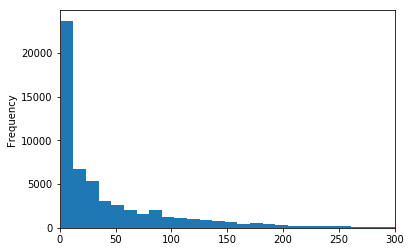

In [33]:
ground_truth["Elements involved"].plot.hist(bins = 98, xlim=[0,300])

Seems like it follows a nice exponnential distribution

In [34]:
def analyseDep(depString):
    """
    Extract interessting numbers about dependances specificaton
    """
    ids = list()
    
    eq = 0
    beq = 0
    leq = 0
    lessThan = 0
    biggerThan = 0
    alternatives = 0
    noSpec = 0
    
    

    for d in depString.split(", "):
        
        alternatives += len(d.split(" | ")) - 1
        
        for d2 in d.split(" | "):

            d2 = d2.split(" (")

            package = d2[0]

            version = ""
            if len(d2) == 2:
                # We have more info about the version
                (req, version) = d2[1][:-1].split(" ")

                if req == "<<" :
                    lessThan +=1 
                    req = "<"
                    
                if req == "<=":
                    leq +=1
                    
                if req == "=":
                    req = "=="
                    eq +=1
                    
                if req == ">=":
                    beq +=1
                    
                if req == ">>":
                    req = ">"
                    biggerThan += 1
            
            else:
                # No info about the version
                noSpec +=1
                
    return lessThan, leq, eq, beq, biggerThan, noSpec, alternatives

ground_truth["<<"], ground_truth["<="], ground_truth["="], ground_truth[">="], ground_truth[">>"], ground_truth["noSpec"], ground_truth["alternatives"] = zip(*ground_truth["Depends"].map(analyseDep))                           

In [35]:
version_spe = ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum()
version_spe

<<                4212
<=                  38
=                19854
>=              119179
>>                 513
noSpec           98732
alternatives     10715
dtype: int64

Using percentage we have

In [36]:
total = ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum().sum()
version_spe = ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum().map(lambda x: x/total * 100)
ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum().map(lambda x: "{0:.3f}%".format(x/total * 100))


<<               1.663%
<=               0.015%
=                7.840%
>=              47.061%
>>               0.203%
noSpec          38.987%
alternatives     4.231%
dtype: object

##### Visualization of the previous countities

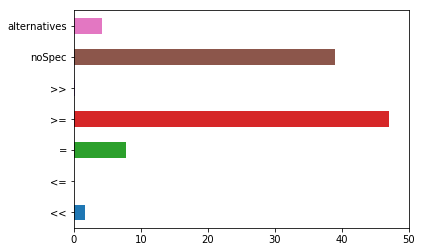

In [37]:
version_spe.plot.barh(x = "percentage", xlim = [0,50])

Here we see that the proportion of `<=` and `>>` is negligible compare to the rest. Indeed, generlly we don't specify that we want strictly higher than a specific version we will rather say this version or higher. Same applies for `<=`, we want stricly less than a specific version in general. 

The vast majority is in `>=` and no spec. 

### Building the dependances trees as a dictionnary

In [ ]:
All_traces = dict()
for index, row in tqdm.tqdm(ground_truth.iterrows()):
    All_traces = {**All_traces, **row['Dependance traces']}
    


In [39]:
All_traces["perl : 5.18.2-2ubuntu1.6"]

{'libbz2-1.0 : 1.0.6-5',
 'libc6 : 2.19-0ubuntu6.14',
 'libdb5.3 : 5.3.28-3ubuntu3.1',
 'libgdbm3 : 1.8.3-12build1',
 'perl-base : 5.18.2-2ubuntu1.6',
 'perl-modules : 5.18.2-2ubuntu1.6',
 'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1'}

In [40]:
All_traces["zlib1g : 1:1.2.8.dfsg-1ubuntu1.1"]

{'libc6 : 2.19-0ubuntu6.14'}

In [41]:
All_traces["libc6 : 2.19-0ubuntu6.14"]

{'libgcc1 : 1:4.9.3-0ubuntu4'}

In [42]:
All_traces['libgcc1 : 1:4.9.3-0ubuntu4']

{'gcc-4.9-base : 4.9.3-0ubuntu4', 'libc6 : 2.19-0ubuntu6.14'}

In [43]:
All_traces["gcc-4.9-base : 4.9.3-0ubuntu4"]

set()

###### Top 5 of Package requiring the most # of dependences

In [44]:
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances" ]].sort_values("Elements involved", ascending=False).iloc[0:5]

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances
id,,,,,,
29528,kubuntu-full,1.308,2626,{'kubuntu-full : 1.308': {'kde-runtime : 4:4.1...,1109,736776922
9612,kubuntu-full,1.308.1.2,2660,{'kubuntu-full : 1.308.1.2': {'kde-runtime : 4...,1109,736776956
26944,gnome-desktop-environment,1:3.8+4ubuntu3,3130,{'gnome-desktop-environment : 1:3.8+4ubuntu3':...,1080,453541476
26915,gnome,1:3.8+4ubuntu3,2830,{'gnome : 1:3.8+4ubuntu3': {'cheese : 3.10.2-0...,1079,453538346
54490,ubuntu-touch,1.126,2466,{'ubuntu-touch : 1.126': {'qtdeclarative5-qtmu...,1063,405727828


###### Top 5 of Package requiring the most space

In [147]:
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances" ]].sort_values("Summing dependances", ascending=False).iloc[0:5]

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances
id,,,,,,
11355,texlive-full,2013.20140215-1ubuntu0.1,14542,{'texlive-full : 2013.20140215-1ubuntu0.1': {'...,281,1684150276
53769,texlive-full,2013.20140215-1,14502,{'texlive-full : 2013.20140215-1': {'texlive-f...,281,1684150236
20985,0ad-dbg,0.0.15+dfsg-3,55484348,{'0ad-dbg : 0.0.15+dfsg-3': {'0ad : 0.0.15+dfs...,165,1145821568
25283,flightgear,3.0.0-1,3834076,{'flightgear : 3.0.0-1': {'libglu1-mesa : 9.0....,268,1090723236
20982,0ad,0.0.15+dfsg-3,2561358,{'0ad : 0.0.15+dfsg-3': {'libxml2 : 2.9.1+dfsg...,164,1090337220


Let's group our list by size and by sum of dependances:

#### Most frequent dependences

In [104]:
from collections import Counter

KeyError: 312312

2864062

In [131]:
d = dict()
all_childs = [x for y in ground_truth["Childrens"].tolist() for x in y ]
tot = len(all_childs)
for child in tqdm(all_childs, total=tot) :
    
    if child not in d:
        d[child] = 1
    else:
        d[child] +=1
    
s = pd.Series(d, name='Dependence Frequency')
ground_truth = ground_truth.assign( Frequency= s)

In [ ]:
ground_truth = ground_truth.assign

In [129]:
ground_truth.columns
#ground_truth["Elements involved"] = ground_truth['Childrens'].map(len)

Index(['Package', 'Version', 'Architecture', 'Size', 'Installed-Size',
       'Maintainer', 'Description', 'parsedFrom', 'Bugs', 'Origin', 'Depends',
       'Recommends', 'Suggests', 'Homepage', 'Source', 'Section', 'Supported',
       'Filename', '#Depends', 'Depends_Parsed', '#Dep2',
       'Summing dependances', 'Dependance traces', 'Childrens', 'ChildrensLen',
       'Recommends_Parsed', 'Frequency', 'Elements involved', 'Fdqw'],
      dtype='object')

In [124]:

ground_truth = ground_truth.assign( Frequency= s)
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances", "Frequency" ]].sort_values(by="Frequency", ascending=False).head(10)

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances,Frequency
id,,,,,,,
129813,gcc-4.9-base,4.9.3-0ubuntu4,15146,{},1,15146,48492
131139,libgcc1,1:4.9.3-0ubuntu4,39194,{},3,4806878,48489
130846,libc6,2.19-0ubuntu6.14,4752538,{},3,4806878,48489
137826,zlib1g,1:1.2.8.dfsg-1ubuntu1.1,49800,{},4,4856678,33209
141353,debconf,1.5.51ubuntu2,136156,{},1,136156,27644
143369,libbz2-1.0,1.0.6-5,33946,{},4,4840824,25717
131890,libpcre3,1:8.31-2ubuntu2.3,144410,{},4,4951288,22260
131070,libffi6,3.1~rc1+r3.0.13-12ubuntu0.2,17864,{},4,4824742,22120
132228,libselinux1,2.2.2-1ubuntu0.1,58690,{},5,5009978,21643


In [92]:
ground_truth = ground_truth.assign( Frequency= s)
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances", "Frequency" ]].sort_values(by="Frequency", ascending=False).head(10)

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances,Frequency
id,,,,,,,
751,gcc-4.9-base,4.9.3-0ubuntu4,15146,{'gcc-4.9-base : 4.9.3-0ubuntu4': {}},1,15146,48385
2077,libgcc1,1:4.9.3-0ubuntu4,39194,{'libgcc1 : 1:4.9.3-0ubuntu4': {'gcc-4.9-base ...,3,4806878,48382
1784,libc6,2.19-0ubuntu6.14,4752538,{'libc6 : 2.19-0ubuntu6.14': {'libgcc1 : 1:4.9...,3,4806878,48382
8618,zlib1g,1:1.2.8.dfsg-1ubuntu1.1,49800,{'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1': {'libc6 :...,4,4856678,33164
12011,debconf,1.5.51ubuntu2,136156,{'debconf : 1.5.51ubuntu2': {}},1,136156,27592
14027,libbz2-1.0,1.0.6-5,33946,{'libbz2-1.0 : 1.0.6-5': {'libc6 : 2.19-0ubunt...,4,4840824,25507
2826,libpcre3,1:8.31-2ubuntu2.3,144410,{'libpcre3 : 1:8.31-2ubuntu2.3': {'libc6 : 2.1...,4,4951288,22205
2008,libffi6,3.1~rc1+r3.0.13-12ubuntu0.2,17864,{'libffi6 : 3.1~rc1+r3.0.13-12ubuntu0.2': {'li...,4,4824742,22112
3162,libselinux1,2.2.2-1ubuntu0.1,58690,{'libselinux1 : 2.2.2-1ubuntu0.1': {'libpcre3 ...,5,5009978,21588


In [93]:
ground_truth["Frequency"].describe()

count    56997.000000
mean        50.236030
std        700.517587
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      48385.000000
Name: Frequency, dtype: float64

In [97]:
ground_truth["Freq in %"] = ground_truth["Frequency"].map(lambda x : x/len(ground_truth) )

In [99]:
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances", "Freq in %" ]].sort_values(by="Freq in %", ascending=False).head(10)

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances,Freq in %
id,,,,,,,
751,gcc-4.9-base,4.9.3-0ubuntu4,15146,{'gcc-4.9-base : 4.9.3-0ubuntu4': {}},1,15146,0.848904
2077,libgcc1,1:4.9.3-0ubuntu4,39194,{'libgcc1 : 1:4.9.3-0ubuntu4': {'gcc-4.9-base ...,3,4806878,0.848852
1784,libc6,2.19-0ubuntu6.14,4752538,{'libc6 : 2.19-0ubuntu6.14': {'libgcc1 : 1:4.9...,3,4806878,0.848852
8618,zlib1g,1:1.2.8.dfsg-1ubuntu1.1,49800,{'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1': {'libc6 :...,4,4856678,0.581855
12011,debconf,1.5.51ubuntu2,136156,{'debconf : 1.5.51ubuntu2': {}},1,136156,0.484096
14027,libbz2-1.0,1.0.6-5,33946,{'libbz2-1.0 : 1.0.6-5': {'libc6 : 2.19-0ubunt...,4,4840824,0.447515
2826,libpcre3,1:8.31-2ubuntu2.3,144410,{'libpcre3 : 1:8.31-2ubuntu2.3': {'libc6 : 2.1...,4,4951288,0.389582
2008,libffi6,3.1~rc1+r3.0.13-12ubuntu0.2,17864,{'libffi6 : 3.1~rc1+r3.0.13-12ubuntu0.2': {'li...,4,4824742,0.387950
3162,libselinux1,2.2.2-1ubuntu0.1,58690,{'libselinux1 : 2.2.2-1ubuntu0.1': {'libpcre3 ...,5,5009978,0.378757


In [107]:
f1 = len(ground_truth[ground_truth["Freq in %"] > 0.05])
f2 = len(ground_truth[ground_truth["Freq in %"] > 0.1])
f3 = len(ground_truth[ground_truth["Freq in %"] > 0.15])
f4 = len(ground_truth[ground_truth["Freq in %"] > 0.2])


print("{} Package Involved in more than 5% ".format(f1))
print("{} Package Involved in more than 10% ".format(f2))
print("{} Package Involved in more than 15% ".format(f3))
print("{} Package Involved in more than 20% ".format(f4))

208 Package Involved in more than 5% 
139 Package Involved in more than 10% 
77 Package Involved in more than 15% 
57 Package Involved in more than 20% 


In [8]:
ls

Attack_vizualization.ipynb   cleaned_and_expanded_gt_Final.csv  matching.py
captured_no_dependances.csv  clean_substract_gt.py              packets
cleaned_and_expanded_gt.csv  csv_to_sql.py                      ubuntu_captures


In [3]:
gt = pd.read_csv("../attack/cleaned_and_expanded_gt.csv")
gt = gt.set_index("id")

In [21]:
gt[gt["Elements involved"] == 1]

,Package,Version,Size,Filename,Summing dependances,Elements involved,Childrens,Frequency,Freq in p
id,,,,,,,,,
11665,anthy-common,9100h-23ubuntu2,2505838,pool/main/a/anthy/anthy-common_9100h-23ubuntu2...,2505838.0,1,{11665},15,0.000263
29129,kdepim-doc,4:4.13.0-0ubuntu1,5009690,pool/universe/k/kdepim/kdepim-doc_4.13.0-0ubun...,5009690.0,1,{29129},1,0.000018
17217,libwebkitgtk-1.0-common,2.4.0-1ubuntu2,107038,pool/main/w/webkitgtk/libwebkitgtk-1.0-common_...,107038.0,1,{17217},1,0.000018
53329,sword-text-tr,1.2-0ubuntu2,1275362,pool/universe/s/sword-text-tr/sword-text-tr_1....,1275362.0,1,{53329},1,0.000018
17220,libwebkitgtk-3.0-common,2.4.0-1ubuntu2,106726,pool/main/w/webkitgtk/libwebkitgtk-3.0-common_...,106726.0,1,{17220},1,0.000018
53328,sword-text-swahili,1.1-0ubuntu1,368046,pool/universe/s/sword-text-swahili/sword-text-...,368046.0,1,{53328},1,0.000018
17222,libwebkitgtk-common-dev,2.4.0-1ubuntu2,61680,pool/main/w/webkitgtk/libwebkitgtk-common-dev_...,61680.0,1,{17222},3,0.000053
46727,outdoors-theme,0.1-0ubuntu2,9330,pool/universe/o/outdoors-theme/outdoors-theme_...,9330.0,1,{46727},1,0.000018
39173,libnetbeans-cvsclient-java,6.5-2,348516,pool/universe/n/netbeans-cvsclient/libnetbeans...,348516.0,1,{39173},97,0.001702


<a id=gstreamer></a>
## `The gstreamer1.0-plugins-base`'s Problem
[Table of content](#tc)

#### Problem found while capturing `gstreamer1.0-plugins-base`

On the docker: 

` 
The following NEW packages will be installed:
  gstreamer1.0-plugins-base iso-codes libasound2 libasound2-data
  libcdparanoia0 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libelf1
  libgl1-mesa-dri libgl1-mesa-glx libglapi-mesa libglib2.0-0 libglib2.0-data
  libglu1-mesa libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libllvm3.4
  libogg0 liborc-0.4-0 libpciaccess0 libtheora0 libtxc-dxtn-s2tc0
  libvisual-0.4-0 libvisual-0.4-plugins libvorbis0a libvorbisenc2 libx11-6
  libx11-data libx11-xcb1 libxau6 libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0
  libxcb-present0 libxcb-sync1 libxcb1 libxdamage1 libxdmcp6 libxext6
  libxfixes3 libxml2 libxshmfence1 libxxf86vm1 sgml-base shared-mime-info
  xml-core
  0 upgraded, 47 newly installed, 0 to remove and 33 not upgraded.
`

So 47 newly dependences
Much more than what we can see when going through the dep field (19 deps)

In [20]:
ground_truth = load_fingerpatch(dbname ="fingerpatch_old", table="ubuntu_packets")
gt =load_fingerpatch(dbname="fingerpatch_old", table="ubuntu_cleaned_packets")

In [171]:
ground_truth[ground_truth["Package"] == "gstreamer1.0-plugins-base"]["Depends"].iloc[0]

'libc6 (>= 2.14), libcdparanoia0 (>= 3.10.2+debian), libglib2.0-0 (>= 2.37.3), libgstreamer1.0-0 (>= 1.2.0), libogg0 (>= 1.0rc3), liborc-0.4-0 (>= 1:0.4.18), libtheora0 (>= 1.0), libvisual-0.4-0 (>= 0.4.0-4), libvorbis0a (>= 1.1.2), libvorbisenc2 (>= 1.1.2), libgstreamer-plugins-base1.0-0 (>= 1.2.4)'

In [173]:
childrens = gt[gt["Package"] == "gstreamer1.0-plugins-base"]["Childrens"].iloc[0]

In [83]:
gt.loc[list(childrens)]["Package"].tolist()
print(len(childrens))

19


But using `apt-cache depends gstreamer1.0-plugins-base` in the docker will lead us to understand why we found 19 and not 47. 

We see that there are not only fields `Depends` but also `Recommends`, `Suggests`, `Pre-Depends`, `Breaks`, ect...

    `Depends`    -> Absolute dependency
    `Pre-Depends`-> Like Depends but even stronger (tell dpkg to install it before)
    `Recommends` -> Strong dependency download enabled by default |--no-install-recommend
    `Suggests`   -> disabled by default |--install-suggests
    
Since our table only contains the absolute dependences, and our docker install the recommends Packages by default, we are missing some packages.

By running `apt-get install --no-install-recommend gstreamer1.0-plugins-base` we get:

`
The following extra packages will be installed:
  iso-codes libcdparanoia0 libglib2.0-0 libgstreamer-plugins-base1.0-0
  libgstreamer1.0-0 libogg0 liborc-0.4-0 libtheora0 libvisual-0.4-0
  libvorbis0a libvorbisenc2
Suggested packages:
  gvfs isoquery libvisual-0.4-plugins gstreamer-codec-install
  gnome-codec-install gstreamer1.0-tools
Recommended packages:
  libglib2.0-data shared-mime-info
The following NEW packages will be installed:
  gstreamer1.0-plugins-base iso-codes libcdparanoia0 libglib2.0-0
  libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libogg0 liborc-0.4-0
  libtheora0 libvisual-0.4-0 libvorbis0a libvorbisenc2
0 upgraded, 12 newly installed, 0 to remove and 37 not upgraded.
Need to get 5300 kB of archives.
`

    
More [here](
https://www.debian.org/doc/debian-policy/ch-relationships.html)

<a id = "gstreamer_fixed"></a>

### Gstreamer fixed

After having included the recommends childrens and suggests we see

In [216]:
recommends_for_gstreamer = ground_truth.loc[list(gt[gt["Package"] == "gstreamer1.0-plugins-base"].iloc[0]["Recommends_Childrens"])]["Package"].tolist()
print(recommends_for_gstreamer)
print("\nlen = ", len(recommends_for_gstreamer))

['libdrm2', 'libvorbis0a', 'libvorbisenc2', 'libxcb-sync1', 'gstreamer1.0-plugins-base', 'libnih-dbus1', 'libxext6', 'libnih1', 'libxfixes3', 'libpcre3', 'shared-mime-info', 'libcgmanager0', 'libxml2', 'libgcc1', 'libvisual-0.4-0', 'libstdc++6', 'libvisual-0.4-plugins', 'libxshmfence1', 'libasound2', 'libasound2-data', 'liblzma5', 'libxcb1', 'libxdamage1', 'libcdparanoia0', 'libxdmcp6', 'libglib2.0-0', 'zlib1g', 'libxxf86vm1', 'libglib2.0-data', 'libglu1-mesa', 'libx11-6', 'libx11-data', 'libx11-xcb1', 'libogg0', 'libxau6', 'libffi6', 'libdbus-1-3', 'libxcb-dri2-0', 'libselinux1', 'libgl1-mesa-glx', 'libxcb-dri3-0', 'libudev1', 'libxcb-glx0', 'gcc-4.8-base', 'libtheora0', 'liborc-0.4-0', 'libgstreamer-plugins-base1.0-0', 'libxcb-present0', 'gcc-4.9-base', 'libgstreamer1.0-0', 'libglapi-mesa', 'iso-codes', 'libc6']

len =  53


We find Still that gstreamer

In [217]:
gt[gt["Package"] == "gstreamer1.0-plugins-base"][["Depends_Elements_involved", "Recommends_Elements_involved","Suggests_Elements_involved"]]

,Depends_Elements_involved,Recommends_Elements_involved,Suggests_Elements_involved
id,,,
909,19,53,394
13076,19,53,395


When disabled, it seems that the field recommended Package doesn't go true the recurtion

In [29]:
gt.columns

Index(['Package', 'Version', 'Size', 'Filename', 'Depends_Summing',
       'Depends_Elements_involved', 'Depends_Childrens', 'Depends_Frequency',
       'Depends_Freq_in_p', 'Recommends_Summing',
       'Recommends_Elements_involved', 'Recommends_Childrens',
       'Recommends_Frequency', 'Recommends_Freq_in_p', 'Suggests_Summing',
       'Suggests_Elements_involved', 'Suggests_Childrens',
       'Suggests_Frequency', 'Suggests_Freq_in_p', 'Depends', 'Recommends',
       'Suggests', 'Depends_Parsed', 'Recommends_Parsed', 'Suggests_Parsed'],
      dtype='object')

In [38]:
gt.loc[list(gt[gt["Package"] == "gstreamer1.0-plugins-base"]['Depends_Childrens'].iloc[0])]["Recommends"]

id
3168                                      
17442                libvisual-0.4-plugins
1786                                      
3336                                      
3337                                      
16203                                     
909                                       
2830                                      
17261                                     
16238                                     
2287                                      
753                                       
2291                                      
14388                                     
13305                                     
2010                                      
2236     libglib2.0-data, shared-mime-info
8766                                      
2079                                      
Name: Recommends, dtype: object

In [37]:
gt.loc[list(gt[gt["Package"] == "gstreamer1.0-plugins-base"]['Depends_Childrens'].iloc[0])]["Suggests"]

id
3168                                                      
17442                                                     
1786             glibc-doc, debconf | debconf-2.0, locales
3336                                                      
3337                                                      
16203                                                     
909                                                   gvfs
2830                                                      
17261                                                     
16238                                                     
2287     libvisual-0.4-plugins, gstreamer-codec-install...
753                                                       
2291         gstreamer1.0-tools, gstreamer1.0-plugins-base
14388                                                     
13305                                             isoquery
2010                                                      
2236                                                 

First level Recommends

<a id = "mueval_problem"></a>
## `libghc-mueval-dev` Problem

[table of content](#tc)

We have : 
`apt-get install libghc-mueval-dev`

`The following NEW packages will be installed:
  binutils cpp cpp-4.8 gcc gcc-4.8 ghc libasan0 libatomic1 libbsd-dev
  libc-dev-bin libc6-dev libcloog-isl4 libffi-dev libgcc-4.8-dev
  libghc-extensible-exceptions-dev libghc-ghc-mtl-dev libghc-ghc-paths-dev
  libghc-haskell-src-dev libghc-hint-dev libghc-monadcatchio-mtl-dev
  libghc-mtl-dev libghc-mueval-dev libghc-random-dev libghc-show-dev
  libghc-simple-reflect-dev libghc-syb-dev libghc-transformers-dev
  libghc-utf8-string-dev libgmp-dev libgmp10 libgmpxx4ldbl libgomp1 libisl10
  libitm1 libmpc3 libmpfr4 libquadmath0 libstdc++-4.8-dev libtsan0
  linux-libc-dev manpages manpages-dev
`




When we look in our `Depends` and `Recommends` we don't find that results (Even when going in the recursion)



In [57]:
print("Depends: \n")
print(ground_through[ground_through["Package"] == "libghc-mueval-dev"]["Depends"].iloc[0])



tmp = parseAndFindDep(ground_through[ground_through["Package"] == "libghc-mueval-dev"]["Depends"].iloc[0], ground_through)

print("\nBut when we parse the Depends field we find only {} i.e. libc6".format(tmp))

Depends: 

libghc-cabal-dev-1.16.0-c6e09, libghc-base-dev-4.6.0.1-8aa5d, libghc-containers-dev-0.5.0.0-ab1da, libghc-directory-dev-1.2.0.1-91a78, libghc-extensible-exceptions-dev-0.1.1.4-255a3, libghc-filepath-dev-1.3.0.1-b12cb, libghc-hint-dev-0.3.3.6-f16df, libghc-mtl-dev-2.1.2-94c72, libghc-process-dev-1.1.0.2-76e05, libghc-show-dev-0.6-f1d78, libghc-simple-reflect-dev-0.3.1-2ae15, libghc-unix-dev-2.6.0.1-f1254, libghc-utf8-string-dev-0.3.7-26a8e, libc6 (>= 2.15)

But when we parse the Depends field we find only {1786} i.e. libc6


Indeed, the `Depends` listed above doesn't appear in our ground_truth:

In [59]:
ground_through[ground_through["Package"] == "libghc-cabal-dev-1.16.0-c6e09"] # Some for the others...

,capture_id,Package,Version,Architecture,Size,Installed-Size,Priority,Maintainer,SHA1,Description,...,Depends,Recommends,Suggests,Homepage,Source,SHA256,Section,Supported,Filename,packageMode
id,,,,,,,,,,,,,,,,,,,,,


But when looking on how actually apt sees the dependences:

`apt-cache depends libghc-mueval-dev`

`
libghc-mueval-dev
  Depends: <libghc-cabal-dev-1.16.0-c6e09>
    ghc
  Depends: <libghc-base-dev-4.6.0.1-8aa5d>
    ghc
  Depends: <libghc-containers-dev-0.5.0.0-ab1da>
    ghc
  Depends: <libghc-directory-dev-1.2.0.1-91a78>
    ghc
  Depends: <libghc-extensible-exceptions-dev-0.1.1.4-255a3>
    libghc-extensible-exceptions-dev
  Depends: <libghc-filepath-dev-1.3.0.1-b12cb>
    ghc
  Depends: <libghc-hint-dev-0.3.3.6-f16df>
    libghc-hint-dev
  Depends: <libghc-mtl-dev-2.1.2-94c72>
    libghc-mtl-dev
  Depends: <libghc-process-dev-1.1.0.2-76e05>
    ghc
  Depends: <libghc-show-dev-0.6-f1d78>
    libghc-show-dev
  Depends: <libghc-simple-reflect-dev-0.3.1-2ae15>
    libghc-simple-reflect-dev
  Depends: <libghc-unix-dev-2.6.0.1-f1254>
    ghc
  Depends: <libghc-utf8-string-dev-0.3.7-26a8e>
    libghc-utf8-string-dev
  Depends: libc6
`

##### It's doing a mapping from those libraries to `ghc` , `libghc-utf8-string-dev` ....

<a id = "recommends_and_suggests"></a>
## Recommends and Suggests
[table of content](#tc)

Is there some packages that have 0 Dependens but have Recommandations?

In [2]:
ground_truth =load_fingerpatch(dbname="fingerpatch", table="ubuntu_packets" )
ground_truth = remove_useless(ground_truth)
    
# Take the smallest packet that have only one Dependences
ground_truth = generate_count_on_depend(ground_truth)

# Take the smallest packet that have only one Dependences
no_deps = ground_truth[ground_truth["#Depends"] == 0].sort_values(by = "#Recommends", ascending=False)

The maximum duplication of rows that have the same Package name and Version is:  1
Total entries after having cleaned:  57167


In [3]:
no_deps[:4][["Package", "Version", "Size", "#Depends", "#Recommends", "Recommends"]]

,Package,Version,Size,#Depends,#Recommends,Recommends
id,,,,,,
24803,edubuntu-fonts,14.03.2,2920,0,50,"fonts-beteckna, fonts-bpg-georgian, fonts-brei..."
54803,ubuntustudio-audio-plugins,0.126,4256,0,47,"abgate, aeolus, amb-plugins, autotalent, blepv..."
205,nagios-plugins-contrib,14.20141104~ubuntu14.04.1,344504,0,39,"libc6 (>= 2.14), libmemcached10, libvarnishapi..."
45813,nagios-plugins-contrib,9.20140106,287216,0,32,"libc6 (>= 2.14), libmemcached10, libvarnishapi..."


Same for suggests? Is there some Package that have no `Depends`, no `Recommends` but have `Suggests` 

In [4]:
no_recommends = ground_truth.sort_values(by = ["#Depends","#Recommends", "#Suggests"], ascending=[True, True, False])
no_recommends[:3][["Package", "Version", "Size", "#Depends", "#Recommends", "#Suggests", "Suggests"]]

,Package,Version,Size,#Depends,#Recommends,#Suggests,Suggests
id,,,,,,,
44734,maint-guide,1.2.32,646130,0,0,10,"doc-base, dh-make, devscripts, fakeroot, linti..."
44735,maint-guide-ca,1.2.32,696328,0,0,10,"doc-base, dh-make, devscripts, fakeroot, linti..."
44736,maint-guide-de,1.2.32,708672,0,0,10,"doc-base, dh-make, devscripts, fakeroot, linti..."


In [5]:
ground_truth[["#Depends","#Recommends", "#Suggests"]].describe()

,#Depends,#Recommends,#Suggests
count,57167.000000,57167.000000,57167.000000
mean,3.973341,0.366750,0.413245
std,5.352422,2.420794,1.657822
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,5.000000,0.000000,0.000000
max,171.000000,141.000000,222.000000


In [6]:
ground_truth[["#Depends","#Recommends", "#Suggests"]].sum()

#Depends       227144
#Recommends     20966
#Suggests       23624
dtype: int64

Let's have an analysis after applying the same dependences extraction on Recommends and Suggests

In [7]:
gt = load_fingerpatch(table="ubuntu_cleaned_packets")
gt[["Depends_Elements_involved", "Recommends_Elements_involved", "Suggests_Elements_involved"]].describe()

,Depends_Elements_involved,Recommends_Elements_involved,Suggests_Elements_involved
count,57165.000000,57165.000000,57165.00000
mean,50.204321,62.038048,134.56713
std,75.582266,88.490301,141.08040
min,1.000000,1.000000,1.00000
25%,6.000000,7.000000,15.00000
50%,20.000000,26.000000,147.00000
75%,64.000000,84.000000,190.00000
max,1080.000000,1577.000000,2703.00000


My explanation about my the `Suggests_Elements_involved` is so big compared to `Recommends_Elements_involved` : 

The suggests elements are usually much more High level than the Recommends or the Depends, leading to a much longer path

<a id='kernels'></a>
## Kernel Packages

Here we are having a close look about the Kernel Package.

More infos [here](https://askubuntu.com/questions/266772/why-are-there-so-many-linux-kernel-packages-on-my-machine-and-what-do-they-a)

[table of content](#tc)

<a id='stats'> </a>
### Stats
Bellow are some global statistics about the Kernel Packages

In [3]:
# Load the cleaned db
gt =load_fingerpatch(dbname="fingerpatch", table="ubuntu_cleaned_packets")
gt_old =load_fingerpatch(dbname="fingerpatch_old", table="ubuntu_cleaned_packets")

ground_truth = load_fingerpatch("ubuntu_packets")
ground_truth = remove_useless(ground_truth)

In [66]:
kernel_keyword = gt_old[gt_old.Package.str.contains("kernel-")]
lin_im = gt_old[gt_old.Package.str.contains("linux-image")]
print("Old db : " + str(len(kernel_keyword))+ " Packages containing `kernel-` key words")
print("Old db : " +str(len(lin_im)) + " Packages containing `linux-image` key words")

# We concatenate both of them
kernel_package = pd.concat([kernel_keyword, lin_im])

kernel_keyword = gt[gt.Package.str.contains("kernel-")]
lin_im = gt[gt.Package.str.contains("linux-image")]
print("\nNew db : " + str(len(kernel_keyword))+ " Packages containing `kernel-` key words")
print("New db : " + str(len(lin_im))+ " Packages containing `linux-image` key words")

# We concatenate both of them
kernel_package = pd.concat([kernel_keyword, lin_im])

Old db : 14 Packages containing `kernel-` key words
Old db : 774 Packages containing `linux-image` key words

New db : 14 Packages containing `kernel-` key words
New db : 786 Packages containing `linux-image` key words


In [67]:
lin_im[lin_im.Package.str.contains("4.1")]

,Package,Version,Size,Filename,Depends_Summing,Depends_Elements_involved,Depends_Childrens,Depends_Frequency,Depends_Freq_in_p,Recommends_Summing,Recommends_Elements_involved,Recommends_Childrens,Recommends_Frequency,Recommends_Freq_in_p,Suggests_Summing,Suggests_Elements_involved,Suggests_Childrens,Suggests_Frequency,Suggests_Freq_in_p
id,,,,,,,,,,,,,,,,,,,
5404,linux-image-4.15.0-1023-azure,4.15.0-1023.24~14.04.1,7607924,pool/main/l/linux-signed-azure/linux-image-4.1...,23975430,15,"{3168, 8129, 8130, 12293, 2440, 7305, 1034, 35...",2,0.000035,38960170,83,"{768, 8320, 57217, 17280, 2436, 517, 12293, 12...",2,0.000035,84381514,190,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",2,0.000035
5405,linux-image-4.15.0-1030-azure,4.15.0-1030.31~14.04.1,7678100,pool/main/l/linux-signed-azure/linux-image-4.1...,24025130,15,"{3168, 8129, 8130, 12293, 2440, 7305, 1034, 35...",2,0.000035,39009870,83,"{768, 8320, 57217, 17280, 2436, 517, 12293, 12...",2,0.000035,84436220,190,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",2,0.000035
5406,linux-image-4.15.0-1031-azure,4.15.0-1031.32~14.04.1+signed1,7680516,pool/main/l/linux-signed-azure/linux-image-4.1...,24033678,15,"{3168, 8129, 8130, 12293, 2440, 7305, 1034, 35...",7,0.000122,39018418,83,"{768, 8320, 57217, 17280, 2436, 517, 12293, 12...",7,0.000122,84432336,190,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",7,0.000122
5811,linux-image-unsigned-4.15.0-1023-azure,4.15.0-1023.24~14.04.1,7661042,pool/main/l/linux-azure/linux-image-unsigned-4...,24028548,15,"{3168, 8129, 8130, 12293, 2440, 7305, 1034, 35...",1,0.000017,39013288,83,"{768, 8320, 57217, 17280, 2436, 517, 12293, 12...",1,0.000017,84434632,190,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",1,0.000017
5812,linux-image-unsigned-4.15.0-1030-azure,4.15.0-1030.31~14.04.1,7722926,pool/main/l/linux-azure/linux-image-unsigned-4...,24069956,15,"{3168, 8129, 8130, 12293, 2440, 7305, 1034, 35...",1,0.000017,39054696,83,"{768, 8320, 57217, 17280, 2436, 517, 12293, 12...",1,0.000017,84481046,190,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",1,0.000017
5813,linux-image-unsigned-4.15.0-1031-azure,4.15.0-1031.32~14.04.1,7726776,pool/main/l/linux-azure/linux-image-unsigned-4...,24079938,15,"{3168, 8129, 8130, 12293, 2440, 7305, 1034, 35...",1,0.000017,39064678,83,"{768, 8320, 57217, 17280, 2436, 517, 12293, 12...",1,0.000017,84478596,190,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",1,0.000017


In [68]:
kernel_package.sample(50)[["Package", "Version", "Size", "Depends_Summing" ,"Depends_Elements_involved", "Recommends_Elements_involved"]]

,Package,Version,Size,Depends_Summing,Depends_Elements_involved,Recommends_Elements_involved
id,,,,,,
10809,linux-image-4.4.0-1002-aws,4.4.0-1002.2,39202682,52279562,54,71
5485,linux-image-4.4.0-31-generic,4.4.0-31.50~14.04.1,17733594,30810474,54,71
5496,linux-image-4.4.0-45-lowlatency,4.4.0-45.66~14.04.1,56430038,69506918,54,71
5517,linux-image-4.4.0-70-generic,4.4.0-70.91~14.04.1,20786262,33863142,54,71
5420,linux-image-4.2.0-27-lowlatency,4.2.0-27.32~14.04.1,55514716,68591596,54,71
5102,linux-image-3.13.0-125-generic,3.13.0-125.174,15475494,28552374,54,71
5550,linux-image-extra-3.13.0-100-generic,3.13.0-100.147,36737100,66043516,60,60
5744,linux-image-extra-4.4.0-128-generic,4.4.0-128.154~14.04.1,36149270,71228948,60,60
5568,linux-image-extra-3.13.0-126-generic,3.13.0-126.175,36520118,65917462,60,60


50 Randomly chosen Package name

In [69]:
kernel_package.describe()


,Size,Depends_Summing,Depends_Elements_involved,Depends_Frequency,Depends_Freq_in_p,Recommends_Summing,Recommends_Elements_involved,Recommends_Frequency,Recommends_Freq_in_p,Suggests_Summing,Suggests_Elements_involved,Suggests_Frequency,Suggests_Freq_in_p
count,8.000000e+02,8.000000e+02,800.000000,800.000000,800.000000,8.000000e+02,800.00000,800.000000,800.000000,8.000000e+02,800.000000,800.000000,800.000000
mean,3.340661e+07,5.469405e+07,52.165000,2.235000,0.000039,5.850459e+07,67.50250,2.271250,0.000040,1.114704e+08,120.403750,2.406250,0.000042
std,1.718012e+07,2.037394e+07,13.059708,3.164616,0.000055,1.948518e+07,8.88418,3.270863,0.000057,5.905369e+07,64.951841,4.969364,0.000087
min,1.754000e+03,6.362000e+03,1.000000,1.000000,0.000017,2.820200e+04,1.00000,1.000000,0.000017,2.820200e+04,1.000000,1.000000,0.000017
25%,1.673806e+07,3.024990e+07,54.000000,1.000000,0.000017,3.469008e+07,60.00000,1.000000,0.000017,6.848764e+07,60.000000,1.000000,0.000017
50%,3.674264e+07,6.510412e+07,54.000000,2.000000,0.000035,6.786362e+07,71.00000,2.000000,0.000035,8.679015e+07,77.000000,2.000000,0.000035
75%,5.190540e+07,6.858892e+07,60.000000,3.000000,0.000052,7.083240e+07,71.00000,3.000000,0.000052,1.434752e+08,189.000000,3.000000,0.000052
max,5.736519e+07,1.064606e+08,108.000000,60.000000,0.001050,1.199406e+08,122.00000,61.000000,0.001067,5.862868e+08,679.000000,108.000000,0.001889


In [70]:
gt.describe()

,Size,Depends_Summing,Depends_Elements_involved,Depends_Frequency,Depends_Freq_in_p,Recommends_Summing,Recommends_Elements_involved,Recommends_Frequency,Recommends_Freq_in_p,Suggests_Summing,Suggests_Elements_involved,Suggests_Frequency,Suggests_Freq_in_p
count,5.716500e+04,5.716500e+04,57165.000000,57165.000000,57165.000000,5.716500e+04,57165.000000,57165.000000,57165.000000,5.716500e+04,57165.00000,57165.000000,57165.000000
mean,2.124526e+06,2.304048e+07,50.204321,50.243086,0.000879,2.769492e+07,62.038048,62.099624,0.001086,5.757258e+07,134.56713,134.670795,0.002356
std,1.650718e+07,4.083340e+07,75.582266,701.632817,0.012273,4.920190e+07,88.490301,810.554640,0.014179,7.496152e+07,141.08040,1691.582538,0.029590
min,7.960000e+02,1.542000e+03,1.000000,1.000000,0.000017,1.542000e+03,1.000000,1.000000,0.000017,1.542000e+03,1.00000,1.000000,0.000017
25%,1.606200e+04,5.332012e+06,6.000000,1.000000,0.000017,6.014552e+06,7.000000,1.000000,0.000017,1.221335e+07,15.00000,1.000000,0.000017
50%,6.322800e+04,1.302922e+07,20.000000,1.000000,0.000017,1.405311e+07,26.000000,1.000000,0.000017,5.394841e+07,147.00000,2.000000,0.000035
75%,3.935700e+05,2.376938e+07,64.000000,3.000000,0.000052,2.900779e+07,84.000000,4.000000,0.000070,7.125092e+07,190.00000,5.000000,0.000087
max,1.067972e+09,1.687588e+09,1080.000000,48530.000000,0.848916,1.729190e+09,1577.000000,50257.000000,0.879126,2.105373e+09,2703.00000,51878.000000,0.907482


In average, the kernel packages are approximatively 10 times bigger

Not a lot of variation in the distribution of the elements involved, which is approximatively the overall mean: 53 elements involved per packages

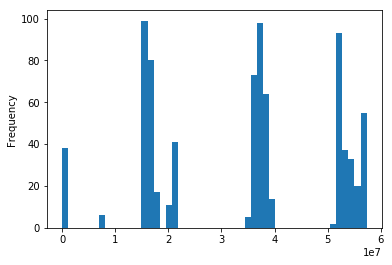

In [71]:
lin_im.Size.plot.hist(bins = 50)

In [72]:
# Package that have size in the first pick at 0 
lin_im[(lin_im.Size < 1e7)]["Package"].sample(20)

id
5797              linux-image-generic-lts-saucy
5816              linux-image-virtual-lts-vivid
5795            linux-image-generic-lts-quantal
5790       linux-image-extra-virtual-lts-utopic
5810                         linux-image-server
17933                       linux-image-virtual
5807           linux-image-lowlatency-lts-vivid
5811     linux-image-unsigned-4.15.0-1023-azure
5817               linux-image-virtual-lts-wily
5406              linux-image-4.15.0-1031-azure
5805                     linux-image-lowlatency
5815             linux-image-virtual-lts-utopic
5814                        linux-image-virtual
17930            linux-image-generic-lts-trusty
5792         linux-image-extra-virtual-lts-wily
5809          linux-image-lowlatency-lts-xenial
5803             linux-image-hwe-generic-trusty
5799             linux-image-generic-lts-utopic
5801               linux-image-generic-lts-wily
10831                           linux-image-aws
Name: Package, dtype: object

In [73]:


lin_im[(lin_im.Size > 1e7) & (lin_im.Size < 3e7)]["Package"].sample(20)

id
5529       linux-image-4.4.0-81-generic
5501       linux-image-4.4.0-53-generic
5138     linux-image-3.13.0-155-generic
5499       linux-image-4.4.0-51-generic
5461      linux-image-4.4.0-130-generic
5160      linux-image-3.13.0-32-generic
5308      linux-image-3.16.0-57-generic
5136     linux-image-3.13.0-153-generic
5284      linux-image-3.16.0-43-generic
10826        linux-image-4.4.0-1028-aws
5298      linux-image-3.16.0-51-generic
5098     linux-image-3.13.0-121-generic
5134     linux-image-3.13.0-151-generic
5244      linux-image-3.13.0-91-generic
5072     linux-image-3.13.0-103-generic
5364      linux-image-3.19.0-47-generic
5374      linux-image-3.19.0-59-generic
5078     linux-image-3.13.0-107-generic
10827        linux-image-4.4.0-1029-aws
5224      linux-image-3.13.0-73-generic
Name: Package, dtype: object

In [74]:
lin_im[(lin_im.Size > 3e7) & (lin_im.Size < 4e7)]["Package"].sample(20)

id
5773       linux-image-extra-4.4.0-70-generic
10817              linux-image-4.4.0-1014-aws
5572     linux-image-extra-3.13.0-133-generic
5746      linux-image-extra-4.4.0-131-generic
5661      linux-image-extra-3.16.0-46-generic
10810              linux-image-4.4.0-1003-aws
5752      linux-image-extra-4.4.0-139-generic
5709      linux-image-extra-3.19.0-69-generic
5600      linux-image-extra-3.13.0-36-generic
5714      linux-image-extra-3.19.0-77-generic
5738      linux-image-extra-4.4.0-112-generic
5703      linux-image-extra-3.19.0-59-generic
5786       linux-image-extra-4.4.0-96-generic
5625      linux-image-extra-3.13.0-68-generic
5642      linux-image-extra-3.13.0-96-generic
5633      linux-image-extra-3.13.0-83-generic
5568     linux-image-extra-3.13.0-126-generic
5641      linux-image-extra-3.13.0-95-generic
5770       linux-image-extra-4.4.0-64-generic
5592      linux-image-extra-3.13.0-24-generic
Name: Package, dtype: object

In [75]:
lin_im[(lin_im.Size > 5e7)]["Package"].sample(20)

id
5289     linux-image-3.16.0-45-lowlatency
5255     linux-image-3.13.0-98-lowlatency
5281     linux-image-3.16.0-40-lowlatency
5167     linux-image-3.13.0-35-lowlatency
5213     linux-image-3.13.0-65-lowlatency
5468     linux-image-4.4.0-134-lowlatency
5474     linux-image-4.4.0-138-lowlatency
5478      linux-image-4.4.0-21-lowlatency
5257     linux-image-3.16.0-25-lowlatency
5436     linux-image-4.4.0-101-lowlatency
5097    linux-image-3.13.0-119-lowlatency
5177     linux-image-3.13.0-41-lowlatency
5137    linux-image-3.13.0-153-lowlatency
5151    linux-image-3.13.0-162-lowlatency
5452     linux-image-4.4.0-119-lowlatency
5426      linux-image-4.2.0-35-lowlatency
5367     linux-image-3.19.0-49-lowlatency
5089    linux-image-3.13.0-113-lowlatency
5476     linux-image-4.4.0-139-lowlatency
5412      linux-image-4.2.0-21-lowlatency
Name: Package, dtype: object

##### Comparing the kernel packages with the rest w.r.t. dependences

We see that the kernel packages are much more stable w.r.t their

In [77]:
lin_im["Depends_Elements_involved"].describe()

count    786.000000
mean      52.338422
std       12.086945
min       14.000000
25%       54.000000
50%       54.000000
75%       60.000000
max       66.000000
Name: Depends_Elements_involved, dtype: float64

In [78]:
gt["Depends_Elements_involved"].describe()

count    57165.000000
mean        50.204321
std         75.582266
min          1.000000
25%          6.000000
50%         20.000000
75%         64.000000
max       1080.000000
Name: Depends_Elements_involved, dtype: float64

In [79]:
g = kernel_package.groupby("Size").count()
g.groupby("Package").count()

,Version,Filename,Depends_Summing,Depends_Elements_involved,Depends_Childrens,Depends_Frequency,Depends_Freq_in_p,Recommends_Summing,Recommends_Elements_involved,Recommends_Childrens,Recommends_Frequency,Recommends_Freq_in_p,Suggests_Summing,Suggests_Elements_involved,Suggests_Childrens,Suggests_Frequency,Suggests_Freq_in_p
Package,,,,,,,,,,,,,,,,,
1,780,780,780,780,780,780,780,780,780,780,780,780,780,780,780,780,780
2,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [90]:
from collections import Counter

def unicity_kernel(metric):
    uniqueness_count = []
    
    # For each kernel package we count the nuber of other packages that have the same size
    for index, row in kernel_package.iterrows():
        uniqueness_count += [len(gt[gt[metric] == row[metric]])]
    
    cnt = Counter()

    # Just count how many kernel packages have the same number of other packages exact size
    for x in uniqueness_count:
        cnt[x] +=1

    # Sum of occurences of unique sized Packages
    total =0
    for x, y in cnt.items():
        total +=  y

    # Translating into percentage
    for x, y in cnt.items():
        print("#unique: ",x, " at ", y/total, " %" )

We see that most of the Package Kernel are unique in size against the whole dataframe i.e. : 95%

In [91]:
unicity_kernel(metric = "Size")

#unique:  1  at  0.95  %
#unique:  2  at  0.01  %
#unique:  3  at  0.005  %
#unique:  44  at  0.00125  %
#unique:  32  at  0.00625  %
#unique:  15  at  0.0025  %
#unique:  8  at  0.00625  %
#unique:  41  at  0.0025  %
#unique:  45  at  0.0025  %
#unique:  6  at  0.00125  %
#unique:  5  at  0.00375  %
#unique:  4  at  0.005  %
#unique:  7  at  0.00375  %


Unicity of Kernel Packages taking Dependences into accounts

In [92]:
unicity_kernel(metric = "Depends_Summing")

#unique:  1  at  0.99  %
#unique:  2  at  0.00625  %
#unique:  3  at  0.00375  %


Unicity of Kernel Packages taking Recommends into accounts

In [95]:
unicity_kernel(metric="Recommends_Summing")

#unique:  1  at  0.99125  %
#unique:  2  at  0.005  %
#unique:  3  at  0.00375  %


In [96]:
unicity_kernel(metric="Suggests_Summing")

#unique:  1  at  0.99  %
#unique:  2  at  0.00625  %
#unique:  3  at  0.00375  %


### Targeting a Kernel Package

##### By not using the ground_thruth

If an attacker is only interested in targeting a Kernel Package, he can simulate all the download of all kernel packages above and have the exact size-to-match recorded in his table. It will be more accurate because of the +- 280 Bytes per packages. 

However, the match will only represent his current machine state (in this case with no dependences installed


##### By using the ground_thruth 

To not only compute the top summing with discarding the most frequent Packages, the attacker can simulate many machine states and keep a record (kernel_package, machine state) -> (List of summing size)


Notice that the number of "machine state" per package is not   $2^{\#children}$ where $\#children$ is the number of the children that the kernel package has. Indeed, it is much less since some Childrens will have strong dependens on other subpackage present in children


##### Problem 

Not all the linux Kernel package are in your initial `apt list`. The full list is available on http://kernel.ubuntu.com/~kernel-ppa/mainline/. We can already see that some architecture make the 

But it seems that we can resolve this problem by runnnig `sudo add-apt-repository ppa:teejee2008/ppa`. Was done on the host, not yet on the docker because the following problem occured afer `installing add-apt-repository`:

`gpg: no ultimately trusted keys found`


but then when lauching the command which is supposed to solve this :

`
sudo add-apt-repository ppa:nilarimogard/webupd8
sudo apt-get update
sudo apt-get install launchpad-getkeys
`

we get the same error:

`gpg: no ultimately trusted keys found`


#### A kernel Package dependences

In [50]:
lin_im.loc[5499]

Package                                              linux-image-4.4.0-51-generic
Version                                                       4.4.0-51.72~14.04.1
Size                                                                     18220882
Filename                        pool/main/l/linux-lts-xenial/linux-image-4.4.0...
Depends_Summing                                                          31297762
Depends_Elements_involved                                                      54
Depends_Childrens               {8320, 17280, 17402, 2436, 12293, 517, 2440, 7...
Depends_Frequency                                                               3
Depends_Freq_in_p                                                     5.24778e-05
Recommends_Summing                                                       35692570
Recommends_Elements_involved                                                   71
Recommends_Childrens            {768, 8320, 17280, 57217, 2436, 517, 12293, 24...
Recommends_Frequ

In [54]:
print(gt.loc[list(lin_im.loc[5499]["Recommends_Childrens"])]["Package"].tolist())

['gettext-base', 'util-linux', 'libtinfo5', 'grub2-common', 'libklibc', 'dpkg', 'debconf', 'libkmod2', 'klibc-utils', 'kmod', 'lsb-base', 'passwd', 'libnih-dbus1', 'libpcre3', 'libnih1', 'debianutils', 'libcgmanager0', 'ucf', 'libc6', 'libgcc1', 'liblzma5', 'libstdc++6', 'libasprintf0c2', 'libsemanage-common', 'libsemanage1', 'libpng12-0', 'zlib1g', 'sysv-rc', 'sysvinit-utils', 'dmsetup', 'libpam0g', 'coreutils', 'module-init-tools', 'libprocps3', 'cpio', 'tzdata', 'libattr1', 'libacl1', 'libblkid1', 'libncurses5', 'insserv', 'libncursesw5', 'mount', 'libaudit-common', 'libaudit1', 'libdbus-1-3', 'busybox-initramfs', 'udev', 'libselinux1', 'libsepol1', 'grub-pc', 'procps', 'libudev1', 'initramfs-tools', 'sensible-utils', 'initramfs-tools-bin', 'initscripts', 'libbz2-1.0', 'gcc-4.8-base', 'findutils', 'grub-common', 'grub-gfxpayload-lists', 'libdevmapper1.02.1', 'gcc-4.9-base', 'libfreetype6', 'libfuse2', 'libpam-modules', 'libuuid1', 'libustr-1.0-1', 'linux-image-4.4.0-51-generic', 'gr

In [82]:
print(ground_truth[ground_truth["Package"] == "linux-generic"][["Package"]])
print(ground_truth[ground_truth["Package"] == "linux-generic"]["Depends"].iloc[0])
print(ground_truth[ground_truth["Package"] == "linux-generic"]["Depends"].iloc[1])


             Package
id                  
4313   linux-generic
17903  linux-generic
linux-image-generic (= 3.13.0.162.172), linux-headers-generic (= 3.13.0.162.172)
linux-image-generic (= 3.13.0.24.28), linux-headers-generic (= 3.13.0.24.28)


The Above Package seems the appropriate package to take when considering to make an kernel update

In [60]:
print(gt[gt["Package"] == "linux-generic"]["Version"])
print("\nOnly {} of those kind in our db".format(len(gt[gt["Package"] == "linux-generic"])))

id
4313     3.13.0.162.172
17903      3.13.0.24.28
Name: Version, dtype: object

Only 2 of those kind in our db


In [99]:
tmp = gt[gt.Package.str.contains("linux-image-4")]
print(len(tmp))
tmp

167


,Package,Version,Size,Filename,Depends_Summing,Depends_Elements_involved,Depends_Childrens,Depends_Frequency,Depends_Freq_in_p,Recommends_Summing,Recommends_Elements_involved,Recommends_Childrens,Recommends_Frequency,Recommends_Freq_in_p,Suggests_Summing,Suggests_Elements_involved,Suggests_Childrens,Suggests_Frequency,Suggests_Freq_in_p
id,,,,,,,,,,,,,,,,,,,
5404,linux-image-4.15.0-1023-azure,4.15.0-1023.24~14.04.1,7607924,pool/main/l/linux-signed-azure/linux-image-4.1...,23975430,15,"{3168, 8129, 8130, 12293, 2440, 7305, 1034, 35...",2,0.000035,38960170,83,"{768, 8320, 57217, 17280, 2436, 517, 12293, 12...",2,0.000035,84381514,190,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",2,0.000035
5405,linux-image-4.15.0-1030-azure,4.15.0-1030.31~14.04.1,7678100,pool/main/l/linux-signed-azure/linux-image-4.1...,24025130,15,"{3168, 8129, 8130, 12293, 2440, 7305, 1034, 35...",2,0.000035,39009870,83,"{768, 8320, 57217, 17280, 2436, 517, 12293, 12...",2,0.000035,84436220,190,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",2,0.000035
5406,linux-image-4.15.0-1031-azure,4.15.0-1031.32~14.04.1+signed1,7680516,pool/main/l/linux-signed-azure/linux-image-4.1...,24033678,15,"{3168, 8129, 8130, 12293, 2440, 7305, 1034, 35...",7,0.000122,39018418,83,"{768, 8320, 57217, 17280, 2436, 517, 12293, 12...",7,0.000122,84432336,190,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",7,0.000122
5407,linux-image-4.2.0-18-generic,4.2.0-18.22~14.04.1,17142006,pool/main/l/linux-lts-wily/linux-image-4.2.0-1...,30218886,54,"{8320, 17280, 2436, 517, 12293, 2440, 1033, 10...",3,0.000052,34613694,71,"{768, 8320, 17280, 57217, 2436, 517, 12293, 24...",3,0.000052,88293844,189,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",3,0.000052
5408,linux-image-4.2.0-18-lowlatency,4.2.0-18.22~14.04.1,55394720,pool/main/l/linux-lts-wily/linux-image-4.2.0-1...,68471600,54,"{8320, 17280, 2436, 517, 12293, 2440, 1033, 10...",2,0.000035,72866408,71,"{768, 8320, 17280, 57217, 2436, 517, 12293, 24...",2,0.000035,126550854,189,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",2,0.000035
5409,linux-image-4.2.0-19-generic,4.2.0-19.23~14.04.1,17149480,pool/main/l/linux-lts-wily/linux-image-4.2.0-1...,30226360,54,"{8320, 17280, 2436, 517, 12293, 2440, 1033, 10...",3,0.000052,34621168,71,"{768, 8320, 17280, 57217, 2436, 517, 12293, 24...",3,0.000052,88324406,189,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",3,0.000052
5410,linux-image-4.2.0-19-lowlatency,4.2.0-19.23~14.04.1,55469236,pool/main/l/linux-lts-wily/linux-image-4.2.0-1...,68546116,54,"{8320, 17280, 2436, 517, 12293, 2440, 1033, 10...",2,0.000035,72940924,71,"{768, 8320, 17280, 57217, 2436, 517, 12293, 24...",2,0.000035,126647902,189,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",2,0.000035
5411,linux-image-4.2.0-21-generic,4.2.0-21.25~14.04.1,17160768,pool/main/l/linux-lts-wily/linux-image-4.2.0-2...,30237648,54,"{8320, 17280, 2436, 517, 12293, 2440, 1033, 10...",3,0.000052,34632456,71,"{768, 8320, 17280, 57217, 2436, 517, 12293, 24...",3,0.000052,88334852,189,"{517, 12293, 12294, 12295, 1033, 1034, 12296, ...",3,0.000052
5412,linux-image-4.2.0-21-lowlatency,4.2.0-21.25~14.04.1,55385672,pool/main/l/linux-lts-wily/linux-image-4.2.0-2...,68462552,54,"{8320, 17280, 2436, 517, 12293, 2440, 1033, 10...",2,0.000035,72857360,71,"{768, 8320, 17280, 57217, 2436, 517, 12293, 24...",2,0.000035,126562062,189,"{517, 12293, 12294, 12296, 12295, 1034, 1033, ...",2,0.000035


#### Tracking by updating a kernel from version x to y 
    
Since we don't have enough above `linux-generic` packages, we will experiment with `linux-image` packages

In [35]:
source = gt.loc[5501]
dest = gt.loc[5529]
print("souce : "+source["Package"]+"\ndest : "+dest["Package"] )

souce : linux-image-4.4.0-53-generic
dest : linux-image-4.4.0-81-generic


In [46]:
s = source["Recommends_Childrens"]
d = dest["Recommends_Childrens"]
d.difference(s)

{5529}

Passing from `4.4-53` to `4.4-81` doesn't need anything new except the underlying kernel package

In [50]:
def remove_dependencies_in_kernel_dest(source_kernel, dest_kernel, df):
    """
    source_kernel and dest_kernel are Index of the df dataframe
    return  lists of dependences that needs to be installed when a victim has source kernel installed 
            and updates it to dest_kernel
    """
    return df.loc[dest_kernel]["Recommends_Childrens"].difference(df.loc[source_kernel]["Recommends_Childrens"])

remove_dependencies_in_kernel_dest(5501, 5529, gt)

{5529}

In [54]:
source = gt.loc[5138]
dest = gt.loc[5529]
print("souce : "+source["Package"]+"\ndest : "+dest["Package"] )
remove_dependencies_in_kernel_dest(5138, 5529, gt)

souce : linux-image-3.13.0-155-generic
dest : linux-image-4.4.0-81-generic


{5529}

In [59]:
print(source["Size"])
print(dest["Size"])

15608584
20857670


In [74]:
print(gt.loc[4313][["Package", "Version", "Recommends_Summing", "Size"]])
print()
print(gt.loc[17903][["Package", "Version", "Recommends_Summing", "Size"]])

Package                linux-generic
Version               3.13.0.162.172
Recommends_Summing         104981120
Size                            1786
Name: 4313, dtype: object

Package               linux-generic
Version                3.13.0.24.28
Recommends_Summing        109122840
Size                           1786
Name: 17903, dtype: object


In [69]:
remove_dependencies_in_kernel_dest(17903, 4313 , gt)

{65, 327, 1002, 4313, 4448, 4449, 5046, 5150, 5591, 5794}

 <a id = "time_changement"></a>
## Time Changement On Crawled Packages
[Table of content](#tc)

After a period of approximatively 1 month.

In [3]:
gt=load_fingerpatch("ubuntu_cleaned_packets")
gt_old=load_fingerpatch("ubuntu_cleaned_packets", "fingerpatch_old")

In [4]:
print("{} more Packages ".format(gt.count().iloc[0] - gt_old.count().iloc[0]))
added_size = gt["Size"].sum() - gt_old["Size"].sum()
print("overall size has been expanded by {}".format(added_size))

168 more Packages 
overall size has been expanded by 1439015618


Now we can have a closer look of what have been changed



In [5]:
gt["Package_Version"] = gt.apply( lambda x:  x["Package"] +" "+x["Version"] , axis = 1)
gt_old["Package_Version"] = gt_old.apply( lambda x:  x["Package"] +" "+x["Version"] , axis = 1)

gt = gt.set_index(["Package_Version"])
gt_old = gt_old.set_index(["Package_Version"])

In [6]:
print("Make sure that both df have unique index to compare them proprely: {} | {}".format(gt.index.is_unique,gt_old.index.is_unique))

Make sure that both df have unique index to compare them proprely: True | True


No we want to see what new packages have been added

All the new packages that have been added versus all the old packages that have been removed

In [24]:
new = gt.index.difference(gt_old.index)
new

Index(['apparmor 2.10.95-0ubuntu2.6~14.04.4',
       'apparmor-docs 2.10.95-0ubuntu2.6~14.04.4',
       'apparmor-easyprof 2.10.95-0ubuntu2.6~14.04.4',
       'apparmor-notify 2.10.95-0ubuntu2.6~14.04.4',
       'apparmor-profiles 2.10.95-0ubuntu2.6~14.04.4',
       'apparmor-utils 2.10.95-0ubuntu2.6~14.04.4', 'apturl 0.5.2ubuntu4.1',
       'apturl-common 0.5.2ubuntu4.1', 'apturl-kde 0.5.2ubuntu4.1',
       'audiofile-tools 0.3.6-2ubuntu0.14.04.3',
       ...
       'vigor 0.016-24build0.14.04.1', 'wireshark 2.6.3-1~ubuntu14.04.1',
       'wireshark-common 2.6.3-1~ubuntu14.04.1',
       'wireshark-dev 2.6.3-1~ubuntu14.04.1',
       'wireshark-doc 2.6.3-1~ubuntu14.04.1',
       'wireshark-gtk 2.6.3-1~ubuntu14.04.1',
       'wireshark-qt 2.6.3-1~ubuntu14.04.1',
       'xul-ext-calendar-timezones 1:60.2.1+build1-0ubuntu0.14.04.2',
       'xul-ext-gdata-provider 1:60.2.1+build1-0ubuntu0.14.04.2',
       'xul-ext-lightning 1:60.2.1+build1-0ubuntu0.14.04.2'],
      dtype='object', name='Pac

In [213]:
old = gt_old.index.difference(gt.index)
old

Index(['apparmor 2.10.95-0ubuntu2.6~14.04.1',
       'apparmor 2.10.95-0ubuntu2.6~14.04.3',
       'apparmor-docs 2.10.95-0ubuntu2.6~14.04.1',
       'apparmor-docs 2.10.95-0ubuntu2.6~14.04.3',
       'apparmor-easyprof 2.10.95-0ubuntu2.6~14.04.1',
       'apparmor-easyprof 2.10.95-0ubuntu2.6~14.04.3',
       'apparmor-notify 2.10.95-0ubuntu2.6~14.04.1',
       'apparmor-notify 2.10.95-0ubuntu2.6~14.04.3',
       'apparmor-profiles 2.10.95-0ubuntu2.6~14.04.1',
       'apparmor-profiles 2.10.95-0ubuntu2.6~14.04.3',
       ...
       'tshark 1.12.1+g01b65bf-4+deb8u11ubuntu0.14.04.1',
       'tzdata 2018e-0ubuntu0.14.04', 'tzdata-java 2018e-0ubuntu0.14.04',
       'wireshark 1.12.1+g01b65bf-4+deb8u11ubuntu0.14.04.1',
       'wireshark-common 1.12.1+g01b65bf-4+deb8u11ubuntu0.14.04.1',
       'wireshark-dev 1.12.1+g01b65bf-4+deb8u11ubuntu0.14.04.1',
       'wireshark-qt 1.12.1+g01b65bf-4+deb8u11ubuntu0.14.04.1',
       'xul-ext-calendar-timezones 1:52.9.1+build3-0ubuntu0.14.04.1',
       'x

In [26]:
linux_news = [x for x in new.tolist() if "linux" in x]
linux_news

['linux-aws 4.4.0.1034.34',
 'linux-aws-cloud-tools-4.4.0-1031 4.4.0-1031.34',
 'linux-aws-cloud-tools-4.4.0-1032 4.4.0-1032.35',
 'linux-aws-cloud-tools-4.4.0-1034 4.4.0-1034.37',
 'linux-aws-headers-4.4.0-1031 4.4.0-1031.34',
 'linux-aws-headers-4.4.0-1032 4.4.0-1032.35',
 'linux-aws-headers-4.4.0-1034 4.4.0-1034.37',
 'linux-aws-tools-4.4.0-1031 4.4.0-1031.34',
 'linux-aws-tools-4.4.0-1032 4.4.0-1032.35',
 'linux-aws-tools-4.4.0-1034 4.4.0-1034.37',
 'linux-azure 4.15.0.1031.18',
 'linux-azure-cloud-tools-4.15.0-1023 4.15.0-1023.24~14.04.1',
 'linux-azure-cloud-tools-4.15.0-1030 4.15.0-1030.31~14.04.1',
 'linux-azure-cloud-tools-4.15.0-1031 4.15.0-1031.32~14.04.1',
 'linux-azure-headers-4.15.0-1023 4.15.0-1023.24~14.04.1',
 'linux-azure-headers-4.15.0-1030 4.15.0-1030.31~14.04.1',
 'linux-azure-headers-4.15.0-1031 4.15.0-1031.32~14.04.1',
 'linux-azure-tools-4.15.0-1023 4.15.0-1023.24~14.04.1',
 'linux-azure-tools-4.15.0-1030 4.15.0-1030.31~14.04.1',
 'linux-azure-tools-4.15.0-1031 

Is there any packages are not updated in version put only on siz?

In [214]:
# Size added by the new Packages - Size substracted by the old packages
gt.loc[new].Size.sum() - gt_old.loc[old].Size.sum()

1006343270

Same has the total sum added : __Only new Packages Influences the Size__

 <a id ="unicity"></a>
## Unicity
Exploring how unique are the size in the whole ground-truth dataframe

[Table of Content](#tc)

In [218]:
gt=load_fingerpatch("ubuntu_cleaned_packets")

In [8]:
# We groupby Size and count the number of occurences and group again on that number of occurences
bySize = gt.groupby(by="Size").count().groupby(by = "Package").count()

# Useful for %tage
total = bySize["Version"].sum()


# Convert the number of occurence to a percentage
unicity_1 =bySize["Version"].map(lambda x : x/total).sort_values(ascending = False).head(5)

# Similar step as above
includingDep = gt.groupby(by="Depends_Summing").count().groupby(by = "Package").count()
total = includingDep["Version"].sum()
unicity_2 = includingDep["Version"].map(lambda x : x/total).sort_values(ascending = False).head(5)

In [9]:
# Get the Packages that are present in at least TOP_X of the package's childrens
TOP_X = 0.2
most_common_dep = gt[gt["Depends_Freq_in_p"] >=TOP_X]
print("The packages that are at least in "+str(TOP_X*100)+"% of other Packages ")
print(gt.loc[most_common_dep.index]["Package"].tolist())

The packages that are at least in 20.0% of other Packages 
['coreutils', 'dpkg', 'fontconfig-config', 'gcc-4.8-base', 'gcc-4.9-base', 'libc6', 'libcomerr2', 'libdb5.3', 'libdbus-1-3', 'libexpat1', 'libffi6', 'libfontconfig1', 'libfreetype6', 'libgcc1', 'libgcrypt11', 'libglib2.0-0', 'libgnutls26', 'libjpeg-turbo8', 'libpam-modules', 'libpam0g', 'libpcre3', 'libpng12-0', 'libselinux1', 'libsepol1', 'libsqlite3-0', 'libssl1.0.0', 'libstdc++6', 'libtasn1-6', 'libuuid1', 'libx11-6', 'libx11-data', 'libxext6', 'libxml2', 'lsb-base', 'passwd', 'perl-base', 'sensible-utils', 'zlib1g', 'debconf', 'debianutils', 'fonts-dejavu-core', 'libaudit-common', 'libaudit1', 'libbz2-1.0', 'libgpg-error0', 'libjpeg8', 'liblzma5', 'libncursesw5', 'libp11-kit0', 'libsemanage-common', 'libsemanage1', 'libtinfo5', 'libustr-1.0-1', 'libxau6', 'libxcb1', 'libxdmcp6', 'ucf']


In [10]:
def create_unicity_df_from_top_most_common(TOP_X, df, mode = "Depends"):
    
    # Get the Packages that are present in at least TOP_X of the package's childrens
    most_common_dep = gt[gt[mode + "_Freq_in_p"] >=TOP_X]
    
    # Creating a dict to get the size from the id of the most common packages
    mst_comm_dep = most_common_dep["Size"]
    mst_comm_dep_dict = mst_comm_dep.to_dict()

    # Removing the most common packages in the dataframe
    gt_without_mcd = df.drop(mst_comm_dep.index)

    # Function to substract the Size of the most common Packages
    def substract_comm(row, mst_comm_dep_dict):
        s = row[mode+"_Summing"]
        for c in row[mode +"_Childrens"]:
            if c in mst_comm_dep_dict :

                s = s - mst_comm_dep_dict[c]

        return s


    sum_size_without_common =gt_without_mcd.apply(lambda x : substract_comm(x, mst_comm_dep_dict), 1)

    # Same has unicity_1 & 2
    grp = sum_size_without_common.groupby(sum_size_without_common).count()
    unicity = grp.groupby(grp).count()
    unicity =unicity.map(lambda x :x/unicity.sum()).sort_values(ascending = False).head(5)
    return unicity

unicity_3 = create_unicity_df_from_top_most_common(TOP_X, gt)

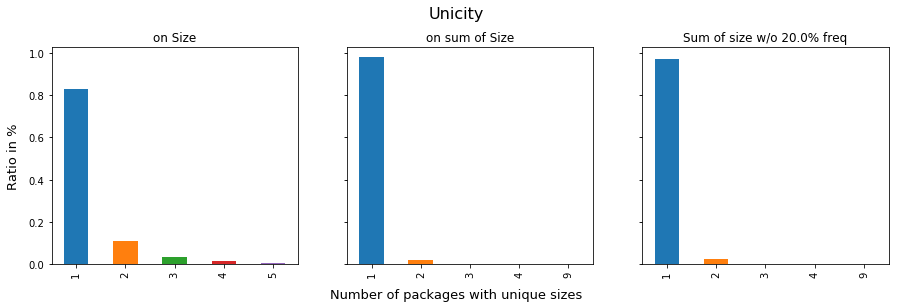

In [11]:
## Plotting the 3 graphs

def create_unicity_plot(unicity_1, unicity_2, unicity_3, t1, t2, t3, t = "Unicity"):
    fig, ax =plt.subplots(1, 3, sharey=True, figsize=(15, 4))
    fig.suptitle(t, fontsize=16, y=1.02)

    # Graph on size
    ax[0].set_title(t1)
    unicity_1.plot.bar(ax = ax[0])
    ax[0].xaxis.set_label_text('')

    # Graph on sum of Size
    ax[1].set_title(t2)
    unicity_2.plot.bar(ax = ax[1])
    ax[1].xaxis.set_label_text('')

    ax[2].set_title(t3)
    unicity_3.plot.bar(ax =ax[2])
    fig.text(0.5, 0.02, 'Number of packages with unique sizes',fontsize=13 ,ha='center', va='center')

    fig.text(0.09, 0.5, 'Ratio in %', ha='center', va='center',fontsize=13, rotation='vertical')

    
create_unicity_plot(unicity_1, unicity_2, unicity_3, "on Size","on sum of Size", "Sum of size w/o "+str(TOP_X*100)+"% freq" )

Reducing this `TOP_X` value, we can get closer than the first graph 

In [12]:
gt["Depends_Freq_in_p"].min()

1.74926e-05

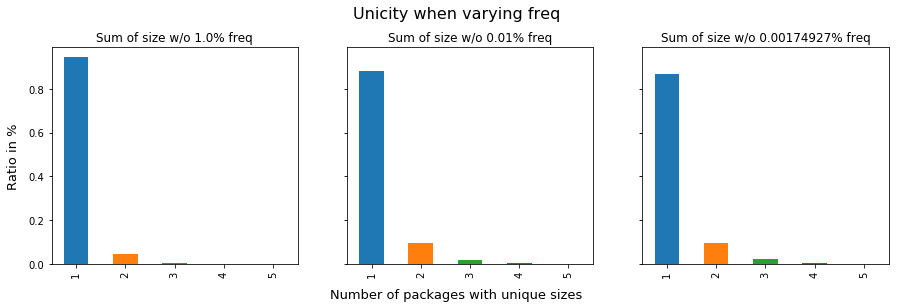

In [13]:
low = 0.01
very_low = 0.0001
lowest = 1.74927e-05

unicity_lowest = create_unicity_df_from_top_most_common(lowest, gt)
unicity_low = create_unicity_df_from_top_most_common(low, gt)
unicity_very_low = create_unicity_df_from_top_most_common(very_low, gt)


t_low ="Sum of size w/o "+str(low*100)+"% freq"
t_very_low ="Sum of size w/o "+str(very_low*100)+"% freq"
t_lowest = "Sum of size w/o "+str(lowest*100)+"% freq"

create_unicity_plot(unicity_low, unicity_very_low, unicity_lowest, t_low, t_very_low, t_lowest, "Unicity when varying freq")

In [14]:
print("---Size--- \n\n",unicity_1, "\n\n---Summing dep---\n\n", unicity_2, "\n\n--Sum w/o "+ str(TOP_X*100)+"% common--- \n\n", unicity_3, "\n")

---Size--- 

 Package
1    0.830502
2    0.111045
3    0.035784
4    0.012521
5    0.004949
Name: Version, dtype: float64 

---Summing dep---

 Package
1    0.981273
2    0.017513
3    0.000946
4    0.000179
9    0.000036
Name: Version, dtype: float64 

--Sum w/o 20.0% common--- 

 1    0.972586
2    0.025538
3    0.001551
4    0.000234
9    0.000036
dtype: float64 



In [15]:
print("---Low--- \n\n",unicity_low, "\n\n---Very_Low---\n\n", unicity_very_low, "\n\n--- Lowest--- \n\n", unicity_lowest, "\n")

---Low--- 

 1    0.944736
2    0.047829
3    0.006306
4    0.000903
5    0.000151
dtype: float64 

---Very_Low---

 1    0.878587
2    0.094974
3    0.018830
4    0.004677
5    0.001527
dtype: float64 

--- Lowest--- 

 1    0.867267
2    0.097450
3    0.021597
4    0.005624
5    0.002475
dtype: float64 



In [16]:
"""both = ground_truth["Size"].append(ground_truth["Summing dependances"])
grouped = both.groupby(both).count()
uniqueness = grouped.groupby(grouped).count().sort_values(ascending = False)
total = uniqueness.sum()
uniqueness.map(lambda x : x/total).head()"""

'both = ground_truth["Size"].append(ground_truth["Summing dependances"])\ngrouped = both.groupby(both).count()\nuniqueness = grouped.groupby(grouped).count().sort_values(ascending = False)\ntotal = uniqueness.sum()\nuniqueness.map(lambda x : x/total).head()'

### Unicity with Recommands and Suggest

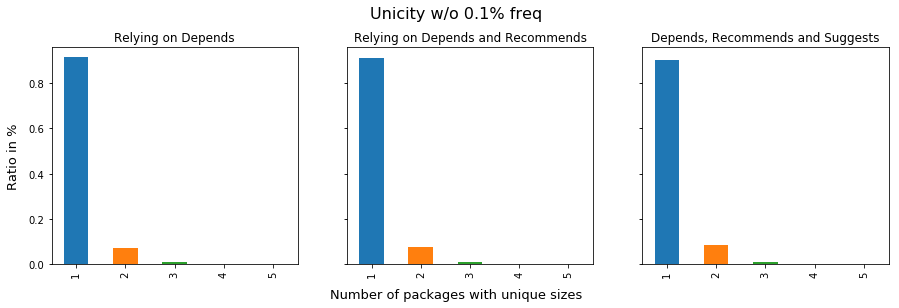

In [24]:
same_top_x = 0.001
unicity_1 = create_unicity_df_from_top_most_common(df=gt, TOP_X=same_top_x, mode = "Depends")
unicity_2 = create_unicity_df_from_top_most_common(df=gt, TOP_X=same_top_x, mode = "Recommends")
unicity_3 = create_unicity_df_from_top_most_common(df=gt, TOP_X=same_top_x, mode = "Suggests")
create_unicity_plot(unicity_1, unicity_2, unicity_3, "Relying on Depends", "Relying on Depends and Recommends", "Depends, Recommends and Suggests", "Unicity w/o {}% freq".format(same_top_x*100))

<a id = "signatures"></a>
## Signatures in apt

[Table of contents](#tc)

Great overview [here](https://debian-handbook.info/browse/stable/sect.package-authentication.html) of how are managed package's signatrue

The key's are managed by `apt-key` and used to verify the signature in the __Release__ file where all the packages metadata are contained with their respectives sha256 and md5 to which in trun verify the integrity and authenticity of a downloaded package.

The Release file is in `var/lib/apt/lists`

## Playground

In [ ]:
gt = load_fingerpatch("ubuntu_cleaned_packets")
ground_throuth = load_fingerpatch("ubuntu_packets")

ground_through = remove_useless(ground_through)


In [20]:
attack_table = load_fingerpatch("ubuntu_captures")

In [27]:
attack_table.loc[12]["HTTP_Seq"][1] == gt.loc[attack_table.loc[12]["truth_id"]]["Filename"]

True

In [30]:
gt[gt["Package"] == "libghc-mueval-dev"]

,Package,Version,Size,Filename,Depends_Summing,Depends_Elements_involved,Depends_Childrens,Depends_Frequency,Depends_Freq_in_p,Recommends_Summing,Recommends_Elements_involved,Recommends_Childrens,Recommends_Frequency,Recommends_Freq_in_p,Suggests_Summing,Suggests_Elements_involved,Suggests_Childrens,Suggests_Frequency,Suggests_Freq_in_p
id,,,,,,,,,,,,,,,,,,,
34833,libghc-mueval-dev,0.9.1-1,119296,pool/universe/h/haskell-mueval/libghc-mueval-d...,4926174,4,"{34833, 1786, 753, 2079}",2,0.000035,4926174,4,"{34833, 1786, 753, 2079}",3,0.000052,61933428,151,"{517, 12293, 12294, 12296, 12295, 12301, 34833...",3,0.000052


In [38]:
    ground_through

,capture_id,Package,Version,Architecture,Size,Installed-Size,Priority,Maintainer,SHA1,Description,...,Depends,Recommends,Suggests,Homepage,Source,SHA256,Section,Supported,Filename,packageMode
id,,,,,,,,,,,,,,,,,,,,,
1,1,apache2,2.4.10-1ubuntu1.1~ubuntu14.04.2,amd64,87626,464,optional,Ubuntu Developers <ubuntu-devel-discuss@lists....,1313dc27572150da4f0ac9975ec8500be72ff513,Apache HTTP Server,...,"lsb-base, procps, perl, mime-support, apache2-...",ssl-cert,"www-browser, apache2-doc, apache2-suexec-prist...",http://httpd.apache.org/,,78746be3b292606ef652921b522e2be396130b301c476e...,web,5y,pool/main/a/apache2/apache2_2.4.10-1ubuntu1.1~...,releases
2,1,apache2-bin,2.4.10-1ubuntu1.1~ubuntu14.04.2,amd64,883356,3446,optional,Ubuntu Developers <ubuntu-devel-discuss@lists....,4a2b690e61fbc5b712c5e0787b7427fb2e2cf042,Apache HTTP Server (binary files and modules),...,"libapr1 (>= 1.5.0), libaprutil1 (>= 1.5.0), li...",,"www-browser, apache2-doc, apache2-suexec-prist...",http://httpd.apache.org/,apache2,7742cd887d507d5f7f554a95a6bcb5798fca08098da933...,httpd,5y,pool/main/a/apache2/apache2-bin_2.4.10-1ubuntu...,releases
3,1,apache2-data,2.4.10-1ubuntu1.1~ubuntu14.04.2,all,159856,702,optional,Ubuntu Developers <ubuntu-devel-discuss@lists....,66494dbf8432da1f29fff16aa737f2de0252bb55,Apache HTTP Server (common files),...,,,,http://httpd.apache.org/,apache2,94305e720661f9de276f949aec0146bc1b7cd61e315c59...,httpd,5y,pool/main/a/apache2/apache2-data_2.4.10-1ubunt...,releases
4,1,apache2-dbg,2.4.10-1ubuntu1.1~ubuntu14.04.2,amd64,2044530,8627,extra,Ubuntu Developers <ubuntu-devel-discuss@lists....,24ba9024163757a784273879d0c6dbd944ab8f76,Apache debugging symbols,...,"apache2, apache2-bin (= 2.4.10-1ubuntu1.1~ubun...",,,http://httpd.apache.org/,apache2,82c2c8413cbffcd6ad1999545436d60c69397c46605c83...,debug,5y,pool/main/a/apache2/apache2-dbg_2.4.10-1ubuntu...,releases
5,1,apache2-dev,2.4.10-1ubuntu1.1~ubuntu14.04.2,amd64,168318,930,optional,Ubuntu Developers <ubuntu-devel-discuss@lists....,185d84dd7419b13da44ec41655186786382be54b,Apache HTTP Server (development headers),...,"openssl, libapr1-dev, libaprutil1-dev, debhelp...",,,http://httpd.apache.org/,apache2,bb7542c5570525d41bbb0a58bee913bf3f6f013a1eec6a...,httpd,5y,pool/main/a/apache2/apache2-dev_2.4.10-1ubuntu...,releases


In [45]:
ground_through = load_fingerpatch("ubuntu_packets")

In [50]:
ground_through[ground_through["Package"] == "libghc-unix"]

,capture_id,Package,Version,Architecture,Size,Installed-Size,Priority,Maintainer,SHA1,Description,...,Depends,Recommends,Suggests,Homepage,Source,SHA256,Section,Supported,Filename,packageMode
id,,,,,,,,,,,,,,,,,,,,,


'libghc-cabal-dev-1.16.0-c6e09, libghc-base-dev-4.6.0.1-8aa5d, libghc-containers-dev-0.5.0.0-ab1da, libghc-directory-dev-1.2.0.1-91a78, libghc-extensible-exceptions-dev-0.1.1.4-255a3, libghc-filepath-dev-1.3.0.1-b12cb, libghc-hint-dev-0.3.3.6-f16df, libghc-mtl-dev-2.1.2-94c72, libghc-process-dev-1.1.0.2-76e05, libghc-show-dev-0.6-f1d78, libghc-simple-reflect-dev-0.3.1-2ae15, libghc-unix-dev-2.6.0.1-f1254, libghc-utf8-string-dev-0.3.7-26a8e, libc6 (>= 2.15)'

{1786}

In [13]:
gt.loc[11209]["Filename"]

'pool/universe/p/proftpd-dfsg/proftpd-doc_1.3.5~rc3-2.1ubuntu2.2_all.deb'

In [16]:
attack_table.loc[9]["HTTP_Seq"]

['GET /ubuntu/pool/universe/p/proftpd-dfsg/proftpd-doc_1.3.5%7erc3-2.1ubuntu2.2_all.deb HTTP/1.1']

In [5]:
gt[gt["Package"] == "ubuntukylin-wallpapers-saucy"]

,Package,Version,Size,Filename,Depends_Summing,Depends_Elements_involved,Depends_Childrens,Depends_Frequency,Depends_Freq_in_p,Recommends_Summing,Recommends_Elements_involved,Recommends_Childrens,Recommends_Frequency,Recommends_Freq_in_p,Suggests_Summing,Suggests_Elements_involved,Suggests_Childrens,Suggests_Frequency,Suggests_Freq_in_p
id,,,,,,,,,,,,,,,,,,,
54796,ubuntukylin-wallpapers-saucy,14.04.0,16680256,pool/universe/u/ubuntukylin-wallpapers/ubuntuk...,16680256,1,{54796},1,0.000017,16680256,1,{54796},1,0.000017,16680256,1,{54796},1,0.000017


In [6]:
ground_through[ground_through["Package"] == "ubuntukylin-wallpapers-saucy"]

,capture_id,Package,Version,Architecture,Size,Installed-Size,Priority,Maintainer,SHA1,Description,...,Depends,Recommends,Suggests,Homepage,Source,SHA256,Section,Supported,Filename,packageMode
id,,,,,,,,,,,,,,,,,,,,,
54796,1,ubuntukylin-wallpapers-saucy,14.04.0,all,16680256,16878,optional,Ubuntu Developers <ubuntu-devel-discuss@lists....,6900e39abe4f1bf35217919c2bbe3af8733947cc,Ubuntu Kylin 13.10 Wallpapers,...,,,,,ubuntukylin-wallpapers,fb99fb5a2686c2c4e0d696299cbe4f1d9aa580fe854d3d...,universe/x11,,pool/universe/u/ubuntukylin-wallpapers/ubuntuk...,releases
119435,1,ubuntukylin-wallpapers-saucy,14.04.0,all,16680256,16878,optional,Ubuntu Developers <ubuntu-devel-discuss@lists....,6900e39abe4f1bf35217919c2bbe3af8733947cc,Ubuntu Kylin 13.10 Wallpapers,...,,,,,ubuntukylin-wallpapers,fb99fb5a2686c2c4e0d696299cbe4f1d9aa580fe854d3d...,universe/x11,,pool/universe/u/ubuntukylin-wallpapers/ubuntuk...,source


In [ ]:
ground_truth["Recommends_Parsed"] = ground_truth["Recommends"].progress_map(lambda x: parseAndFindDep(x, ground_truth))

In [17]:
ground_truth["Depends_Parsed"] = ground_truth["Depends"].progress_map(lambda x: parseAndFindDep(x, ground_truth))

KeyboardInterrupt: 

In [8]:
ground_truth = ground_truth.fillna("")
#ground_truth["#Depends"] = ground_truth["Depends"].map(lambda x: 0 if x == "" else len(x.split(",")))
#ground_truth = ground_truth.sort_values(by = "#Depends", ascending=True)

In [ ]:
ground_truth["Depends_Parsed"] = ground_truth["Depends"].progress_map(lambda x: parseAndFindDep(x, ground_truth))

In [14]:
import numpy as np
import dask.dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count
from dask.diagnostics import ProgressBar



cores = cpu_count() #Number of CPU cores available

dground_truth = dd.from_pandas(ground_truth, npartitions=2*cores)


with ProgressBar():
    ground_truth["Depends_Parsed"] = dground_truth.map_partitions(lambda df: df["Depends"].map((lambda row: parseAndFindDep(row, ground_truth)))).compute(get=get) 

[########################################] | 100% Completed |  9min 21.9s


In [ ]:
import numpy as np
import dask.dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count
from dask.diagnostics import ProgressBar



cores = cpu_count() #Number of CPU cores available

dground_truth = dd.from_pandas(ground_truth, npartitions=cores)


with ProgressBar():
    ground_truth["Recommends_Parsed"] = dground_truth.map_partitions(lambda df: df["Recommends"].map((lambda row: parseAndFindDep(row, ground_truth)))).compute(get=get)

In [19]:
gt = pd.read_csv("cleaned_and_expanded_gt_done.csv")
gt = gt.set_index("id")


Index(['Package', 'Version', 'Architecture', 'Size', 'Installed-Size',
       'Maintainer', 'Description', 'parsedFrom', 'Bugs', 'Origin', 'Depends',
       'Recommends', 'Suggests', 'Homepage', 'Source', 'Section', 'Supported',
       'Filename', '#Depends'],
      dtype='object')

In [14]:
gt.columns

Index(['Package', 'Version', 'Size', 'Filename', 'Depends_Summing',
       'Depends_Elements_involved', 'Depends_Childrens', 'Depends_Frequency',
       'Depends_Freq_in_p', 'Recommends_Summing',
       'Recommends_Elements_involved', 'Recommends_Childrens',
       'Recommends_Frequency', 'Recommends_Freq_in_p', 'Suggests_Summing',
       'Suggests_Elements_involved', 'Suggests_Childrens',
       'Suggests_Frequency', 'Suggests_Freq_in_p'],
      dtype='object')

In [29]:
ground_truth[ground_truth["Suggests"] == ""]

,Package,Version,Architecture,Size,Installed-Size,Maintainer,Description,parsedFrom,Bugs,Origin,...,Recommends,Suggests,Homepage,Source,Section,Supported,Filename,#Depends,#Recommends,#Suggests
id,,,,,,,,,,,,,,,,,,,,,
129061,apache2,2.4.10-1ubuntu1.1~ubuntu14.04.2,amd64,87626,464,Ubuntu Developers <ubuntu-devel-discuss@lists....,Apache HTTP Server,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,...,ssl-cert,,http://httpd.apache.org/,,web,5y,pool/main/a/apache2/apache2_2.4.10-1ubuntu1.1~...,6,1,0
129062,apache2-bin,2.4.10-1ubuntu1.1~ubuntu14.04.2,amd64,883356,3446,Ubuntu Developers <ubuntu-devel-discuss@lists....,Apache HTTP Server (binary files and modules),packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,...,,,http://httpd.apache.org/,apache2,httpd,5y,pool/main/a/apache2/apache2-bin_2.4.10-1ubuntu...,12,0,0
129063,apache2-data,2.4.10-1ubuntu1.1~ubuntu14.04.2,all,159856,702,Ubuntu Developers <ubuntu-devel-discuss@lists....,Apache HTTP Server (common files),packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,...,,,http://httpd.apache.org/,apache2,httpd,5y,pool/main/a/apache2/apache2-data_2.4.10-1ubunt...,0,0,0
129064,apache2-dbg,2.4.10-1ubuntu1.1~ubuntu14.04.2,amd64,2044530,8627,Ubuntu Developers <ubuntu-devel-discuss@lists....,Apache debugging symbols,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,...,,,http://httpd.apache.org/,apache2,debug,5y,pool/main/a/apache2/apache2-dbg_2.4.10-1ubuntu...,2,0,0
129065,apache2-dev,2.4.10-1ubuntu1.1~ubuntu14.04.2,amd64,168318,930,Ubuntu Developers <ubuntu-devel-discuss@lists....,Apache HTTP Server (development headers),packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,...,,,http://httpd.apache.org/,apache2,httpd,5y,pool/main/a/apache2/apache2-dev_2.4.10-1ubuntu...,5,0,0
129066,apache2-doc,2.4.10-1ubuntu1.1~ubuntu14.04.2,all,2642890,19464,Ubuntu Developers <ubuntu-devel-discuss@lists....,Apache HTTP Server (on-site documentation),packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,...,apache2,,http://httpd.apache.org/,apache2,doc,5y,pool/main/a/apache2/apache2-doc_2.4.10-1ubuntu...,0,1,0
129067,apache2-mpm-event,2.4.10-1ubuntu1.1~ubuntu14.04.2,amd64,1468,22,Ubuntu Developers <ubuntu-devel-discuss@lists....,transitional event MPM package for apache2,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,...,,,http://httpd.apache.org/,apache2,web,5y,pool/main/a/apache2/apache2-mpm-event_2.4.10-1...,1,0,0
129068,apache2-mpm-prefork,2.4.10-1ubuntu1.1~ubuntu14.04.2,amd64,1470,22,Ubuntu Developers <ubuntu-devel-discuss@lists....,transitional prefork MPM package for apache2,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,...,,,http://httpd.apache.org/,apache2,net,5y,pool/main/a/apache2/apache2-mpm-prefork_2.4.10...,1,0,0
129069,apache2-mpm-worker,2.4.10-1ubuntu1.1~ubuntu14.04.2,amd64,1470,22,Ubuntu Developers <ubuntu-devel-discuss@lists....,transitional worker MPM package for apache2,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,...,,,http://httpd.apache.org/,apache2,net,5y,pool/main/a/apache2/apache2-mpm-worker_2.4.10-...,1,0,0


In [164]:
ground_truth.loc[147046]

Package                                                          locales
Version                                              2.13+git20120306-12
Architecture                                                         all
Size                                                             2700796
Installed-Size                                                      9012
Maintainer                          Martin Pitt <martin.pitt@ubuntu.com>
Description                              common files for locale support
parsedFrom             packages/archive.ubuntu.com_ubuntu_dists_trust...
Bugs                          https://bugs.launchpad.net/ubuntu/+filebug
Origin                                                            Ubuntu
Depends                libc6 (>= 2.9-0ubuntu10) | libc6.1 (>= 2.9-0ub...
Recommends                                                              
Suggests                                                                
Homepage                                           

In [155]:
ground_truth.loc[130675]

Package                                            language-pack-wa-base
Version                                                 1:14.04+20150804
Architecture                                                         all
Size                                                                9008
Installed-Size                                                        74
Maintainer             Language pack maintainers <language-packs@ubun...
Description                            translations for language Walloon
parsedFrom             packages/archive.ubuntu.com_ubuntu_dists_trust...
Bugs                          https://bugs.launchpad.net/ubuntu/+filebug
Origin                                                            Ubuntu
Depends                locales (>= 2.3.6), language-pack-wa (>= 1:14....
Recommends                                                              
Suggests                                                                
Homepage                                           

In [19]:
l = []
l.append(2)
l

[2]